In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from src.sanity import *

from src.load_datasets import load_power_consumption

from src.utils import (
    show_dataset,
    show_series,
    plot_metrics,
    test_train_split,
    seperate_target,
    plot_tf_training_history,
)

from src.features import (
    create_lag_feature,
    create_datetime_feature,
    create_cyclic_feature,
    create_window_feature,
    cast_to_float,
)

from src.evaluation import evaluate

In [2]:
np.random.seed(80)
plt.style.use("seaborn-v0_8-darkgrid")
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

%config InlineBackend.figure_format = 'retina'

In [3]:
dataframe = (
    load_power_consumption()
    .pipe(format_datetime, col="DateTime")
    .pipe(set_index, col="DateTime")
    .pipe(interpolate_column)
    .pipe(resample_Data, freq="1H")
    .pipe(replace_null)
)

print(f"dataframe shape {dataframe.shape}")

print(dataframe.info())

dataframe.head()

format_datetime: DF Shape (52416, 9)
set_index: DF Shape (52416, 8)
interpolate_columns: DF Shape (52416, 8)
resample_Data: DF Shape (8736, 8)
No Null Value Found
dataframe shape (8736, 8)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8736 entries, 2017-01-01 00:00:00 to 2017-12-30 23:00:00
Freq: H
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Temperature                8736 non-null   float64
 1   Humidity                   8736 non-null   float64
 2   Wind Speed                 8736 non-null   float64
 3   general diffuse flows      8736 non-null   float64
 4   diffuse flows              8736 non-null   float64
 5   Zone 1 Power Consumption   8736 non-null   float64
 6   Zone 2  Power Consumption  8736 non-null   float64
 7   Zone 3  Power Consumption  8736 non-null   float64
dtypes: float64(8)
memory usage: 614.2 KB
None


,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption
DateTime,,,,,,,,
2017-01-01 00:00:00,6.196833,75.066667,0.081833,0.063500,0.098833,29197.974683,18026.747720,19252.048193
2017-01-01 01:00:00,5.548833,77.583333,0.082000,0.056833,0.112500,24657.215190,16078.419453,17042.891567
2017-01-01 02:00:00,5.054333,78.933333,0.082333,0.063000,0.129167,22083.037973,14330.699088,15676.144578
2017-01-01 03:00:00,5.004333,77.083333,0.082833,0.059833,0.141000,20811.139240,13219.452887,14883.855422
2017-01-01 04:00:00,5.097667,74.050000,0.082333,0.058000,0.122833,20475.949367,12921.580547,14317.108433


In [4]:
dataframe.isna().sum()

Temperature                  0
Humidity                     0
Wind Speed                   0
general diffuse flows        0
diffuse flows                0
Zone 1 Power Consumption     0
Zone 2  Power Consumption    0
Zone 3  Power Consumption    0
dtype: int64

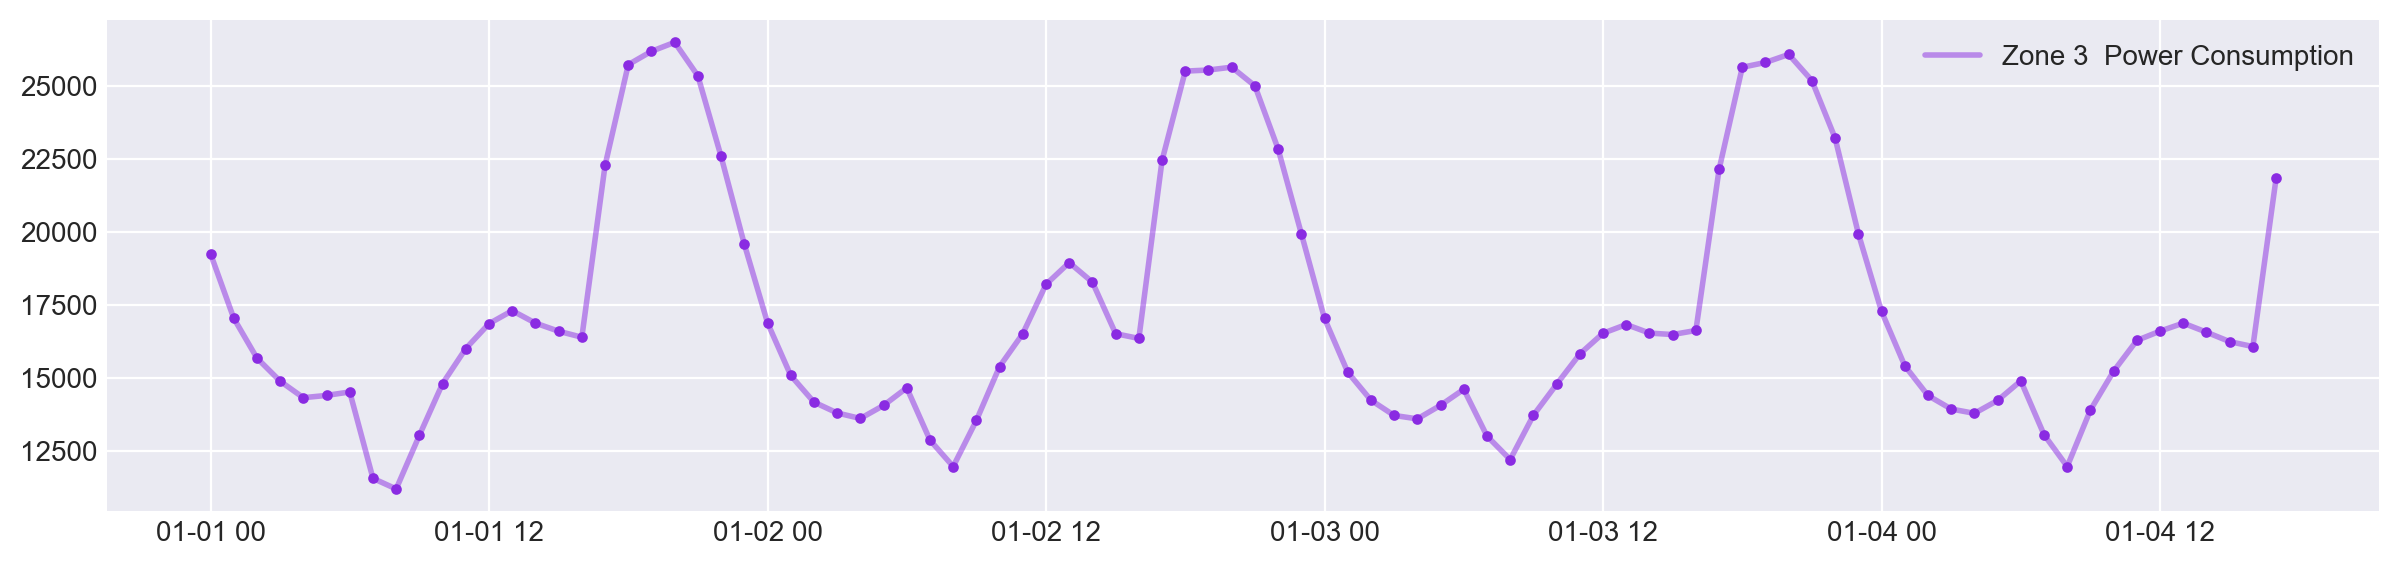

In [5]:
show_dataset(dataframe[:90], columns=["Zone 3  Power Consumption"])

In [6]:
dt_features = [
    "dayofweek",
    "quarter",
    "month",
    "year",
    "dayofyear",
    "dayofmonth",
    "weekofyear",
    "dayofweek",
    "is_week_end",
    "is_week_day",
]
cl_features = ["day", "month", "year"]
lags = [1, 2]
window_length = 3

target_column = "Zone 3  Power Consumption"
TEST_SIZE = 30

In [7]:
train_data, test_data = test_train_split(dataframe, test_size=TEST_SIZE)

print(f"Train Size after Test_Train Split: {train_data.shape}")
print(f"Test  Size after Test_Train Split: {test_data.shape} ")

build_features = lambda df: (
    df.pipe(create_lag_feature, column=target_column, lags=lags)
    .pipe(create_window_feature, column=target_column, window_len=window_length)
    .pipe(create_datetime_feature, features_name=dt_features)
    .pipe(create_cyclic_feature, features_name=cl_features)
    .pipe(cast_to_float)
)

train_data_feat = build_features(train_data)
test_data_feat = build_features(test_data)

print(f"train_data shape after Feature Union {train_data_feat.shape}")
print(f"test_data shape after Feature Union {test_data_feat.shape}")

train_data_feat = train_data_feat[max(*lags) :]
test_data_feat.fillna(method="backfill", inplace=True)

print(f"train_data shape after Null Removal {train_data_feat.shape}")
print(f"test_data shape after Null Removal {test_data_feat.shape}")

train_x, train_y = seperate_target(train_data_feat, target_column)
test_x, test_y = seperate_target(test_data_feat, target_column)

test_data_feat.head()

Train Size after Test_Train Split: (8706, 8)
Test  Size after Test_Train Split: (30, 8) 
train_data shape after Feature Union (8706, 27)
test_data shape after Feature Union (30, 27)
train_data shape after Null Removal (8704, 27)
test_data shape after Null Removal (30, 27)


,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption,Zone 3 Power Consumption_lag_1,Zone 3 Power Consumption_lag_2,...,dayofmonth,weekofyear,is_week_end,is_week_day,sin_day,cos_day,sin_month,cos_month,sin_year,cos_year
DateTime,,,,,,,,,,,,,,,,,,,,,
2017-12-29 18:00:00,13.473333,49.991667,0.079333,3.185333,3.268833,39196.958175,33501.073948,16258.343338,16258.343338,16258.343338,...,29.0,52.0,0.0,0.0,-0.663634,-0.748058,-0.536573,0.843854,-0.989354,0.14553
2017-12-29 19:00:00,13.415000,49.985000,0.078500,0.055500,0.100167,38381.749048,33111.997543,16456.182472,16258.343338,16258.343338,...,29.0,52.0,0.0,0.0,-0.663634,-0.748058,-0.536573,0.843854,-0.989354,0.14553
2017-12-29 20:00:00,13.623333,50.211667,0.078167,0.064167,0.104500,38146.514577,32833.998158,16635.774308,16456.182472,16258.343338,...,29.0,52.0,0.0,0.0,-0.663634,-0.748058,-0.536573,0.843854,-0.989354,0.14553
2017-12-29 21:00:00,13.501667,51.808333,0.077167,0.057500,0.107500,36578.960708,32103.099108,15979.831933,16635.774308,16456.182472,...,29.0,52.0,0.0,0.0,-0.663634,-0.748058,-0.536573,0.843854,-0.989354,0.14553
2017-12-29 22:00:00,13.401667,53.281667,0.077667,0.063667,0.102000,33705.449937,29626.265727,14615.126050,15979.831933,16635.774308,...,29.0,52.0,0.0,0.0,-0.663634,-0.748058,-0.536573,0.843854,-0.989354,0.14553


In [8]:
resultsDict = {}
predictionsDF = pd.DataFrame(index=test_x.index)

### KNeighborsRegressor

In [9]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

model_name = "KNeighborsRegressor"

estimator_ = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "regressor",
            KNeighborsRegressor(n_neighbors=2),
        ),
    ]
)

param_grid = {"regressor__n_neighbors": [2, 3, 5, 7, 12, 15]}

cross_validator = TimeSeriesSplit(n_splits=3)

gsearch = GridSearchCV(
    estimator=estimator_,
    cv=cross_validator,
    param_grid=param_grid,
    refit=True,
    verbose=3,
    n_jobs=1,
)

gsearch.fit(train_x, train_y.to_numpy().flatten())

print(gsearch.best_score_, gsearch.best_params_)

model = gsearch.best_estimator_

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[target_column].to_numpy(), yhat)
predictionsDF[model_name] = yhat

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3] END ..........regressor__n_neighbors=2;, score=0.217 total time=   0.2s
[CV 2/3] END ..........regressor__n_neighbors=2;, score=0.748 total time=   0.0s
[CV 3/3] END ..........regressor__n_neighbors=2;, score=0.516 total time=   0.0s
[CV 1/3] END ..........regressor__n_neighbors=3;, score=0.236 total time=   0.0s
[CV 2/3] END ..........regressor__n_neighbors=3;, score=0.759 total time=   0.1s
[CV 3/3] END ..........regressor__n_neighbors=3;, score=0.525 total time=   1.3s
[CV 1/3] END ..........regressor__n_neighbors=5;, score=0.238 total time=   1.7s
[CV 2/3] END ..........regressor__n_neighbors=5;, score=0.764 total time=   0.9s
[CV 3/3] END ..........regressor__n_neighbors=5;, score=0.528 total time=   1.1s
[CV 1/3] END ..........regressor__n_neighbors=7;, score=0.215 total time=   1.4s
[CV 2/3] END ..........regressor__n_neighbors=7;, score=0.763 total time=   1.0s
[CV 3/3] END ..........regressor__n_neighbors=7;,

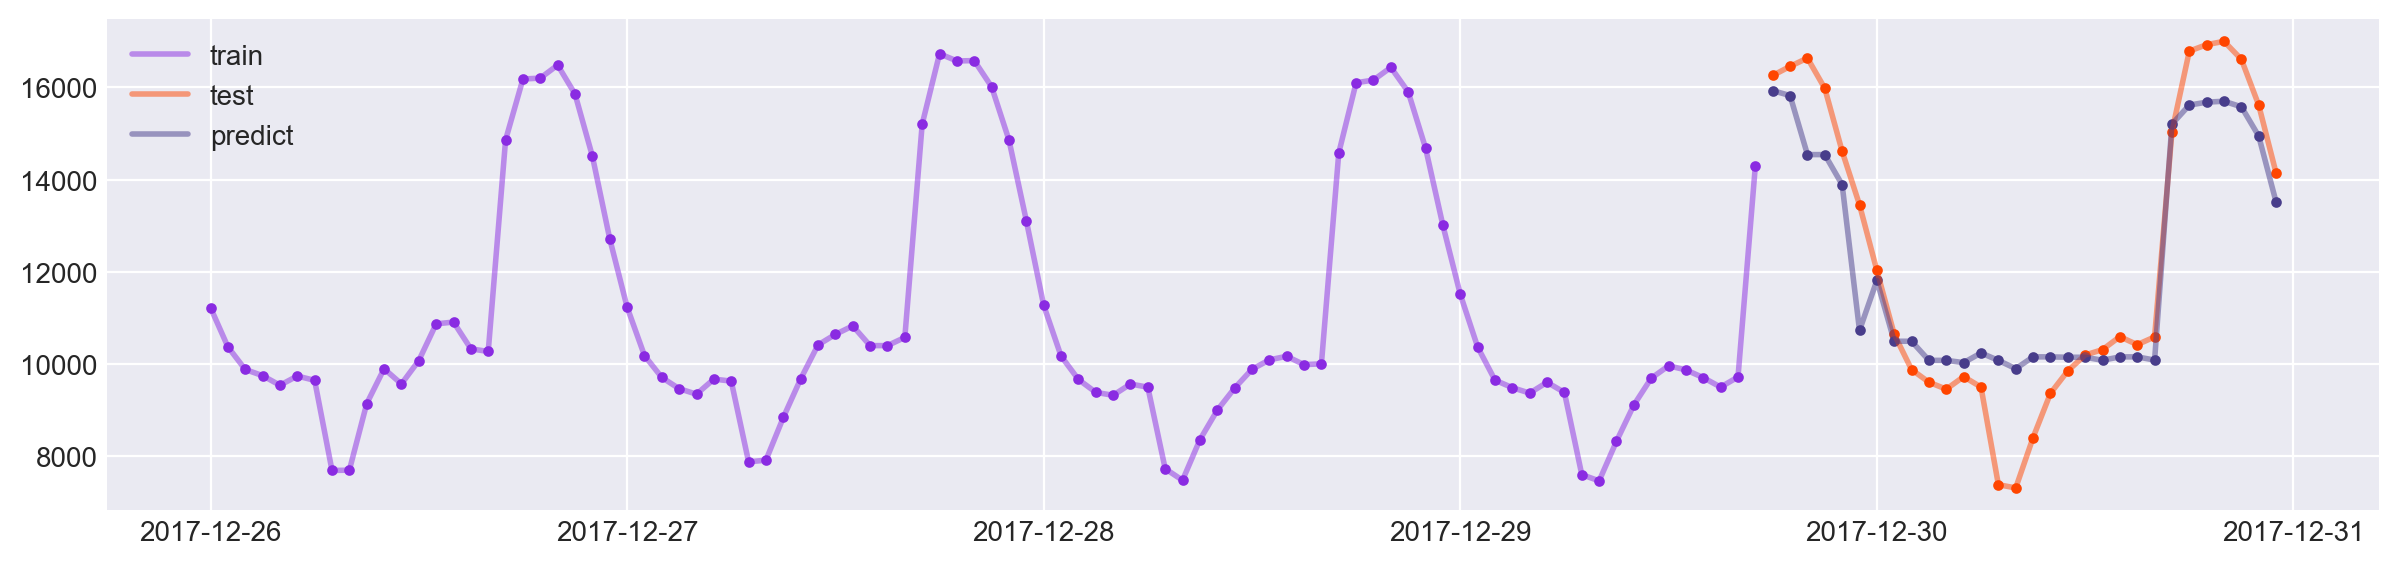

In [10]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### Ridge Model

In [11]:
from sklearn.linear_model import BayesianRidge

model, yhat, model_name = None, None, None
model_name = "BayesianRidge"

model = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "regressor",
            BayesianRidge(fit_intercept=True, verbose=True, compute_score=True),
        ),
    ]
)


model.fit(train_x, train_y.to_numpy().flatten())
yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[target_column].to_numpy(), yhat)
predictionsDF[model_name] = yhat

Convergence after  13  iterations


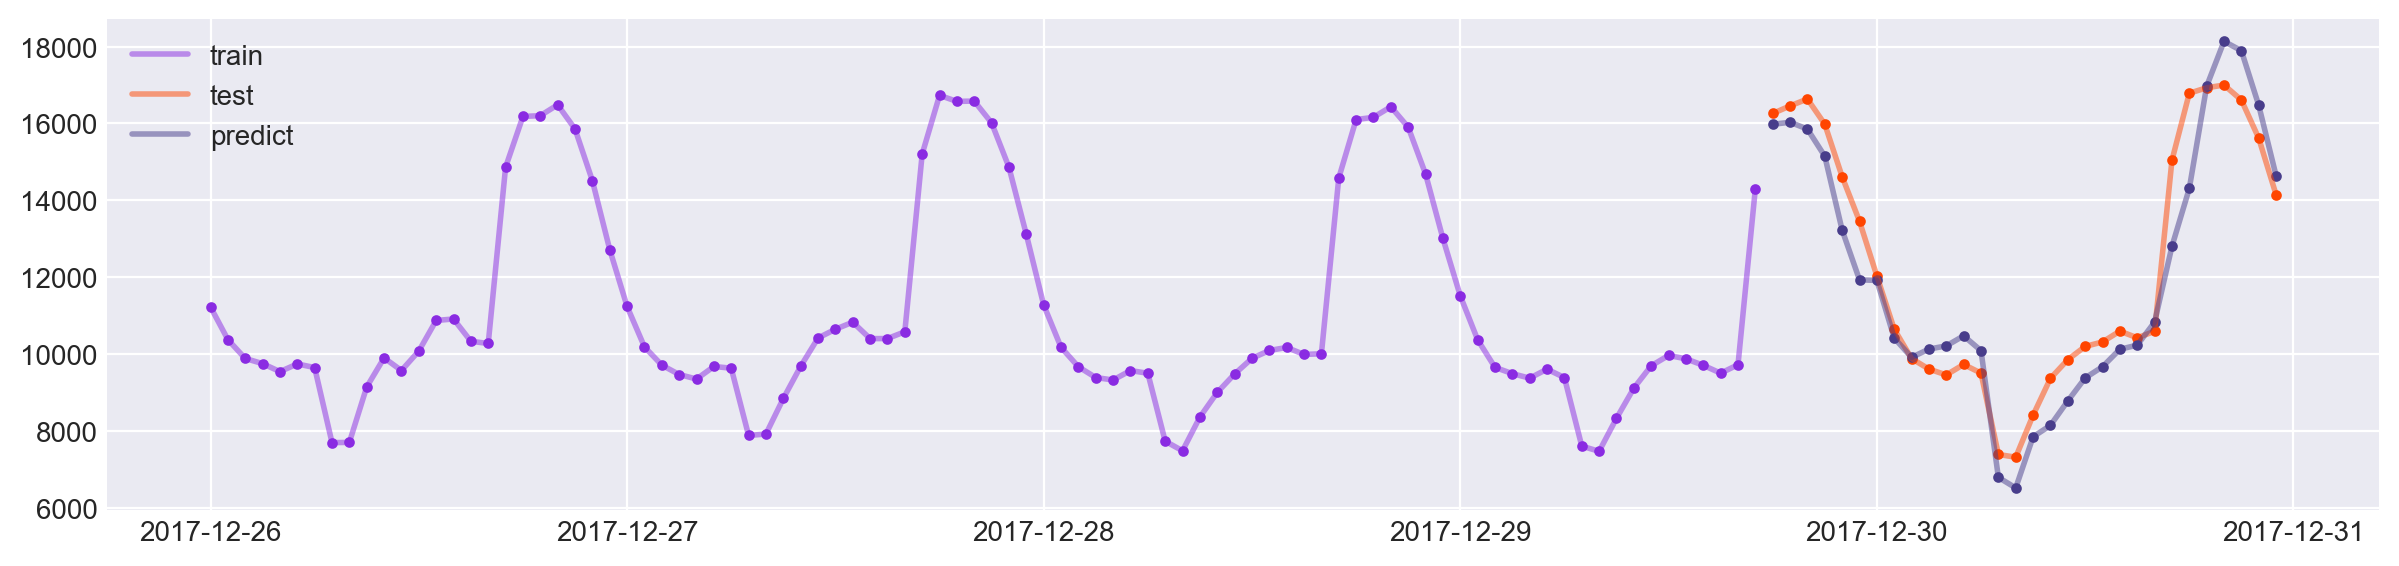

In [12]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### LassoCV Regressor

In [13]:
from sklearn.linear_model import LassoCV

model, yhat, model_name = None, None, None

model_name = "LassoCV"

model = Pipeline(
    [("scaler", StandardScaler()), ("regressor", LassoCV(fit_intercept=True))]
)

model.fit(train_x, train_y.to_numpy().flatten())
yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[target_column].to_numpy(), yhat)
predictionsDF[model_name] = yhat

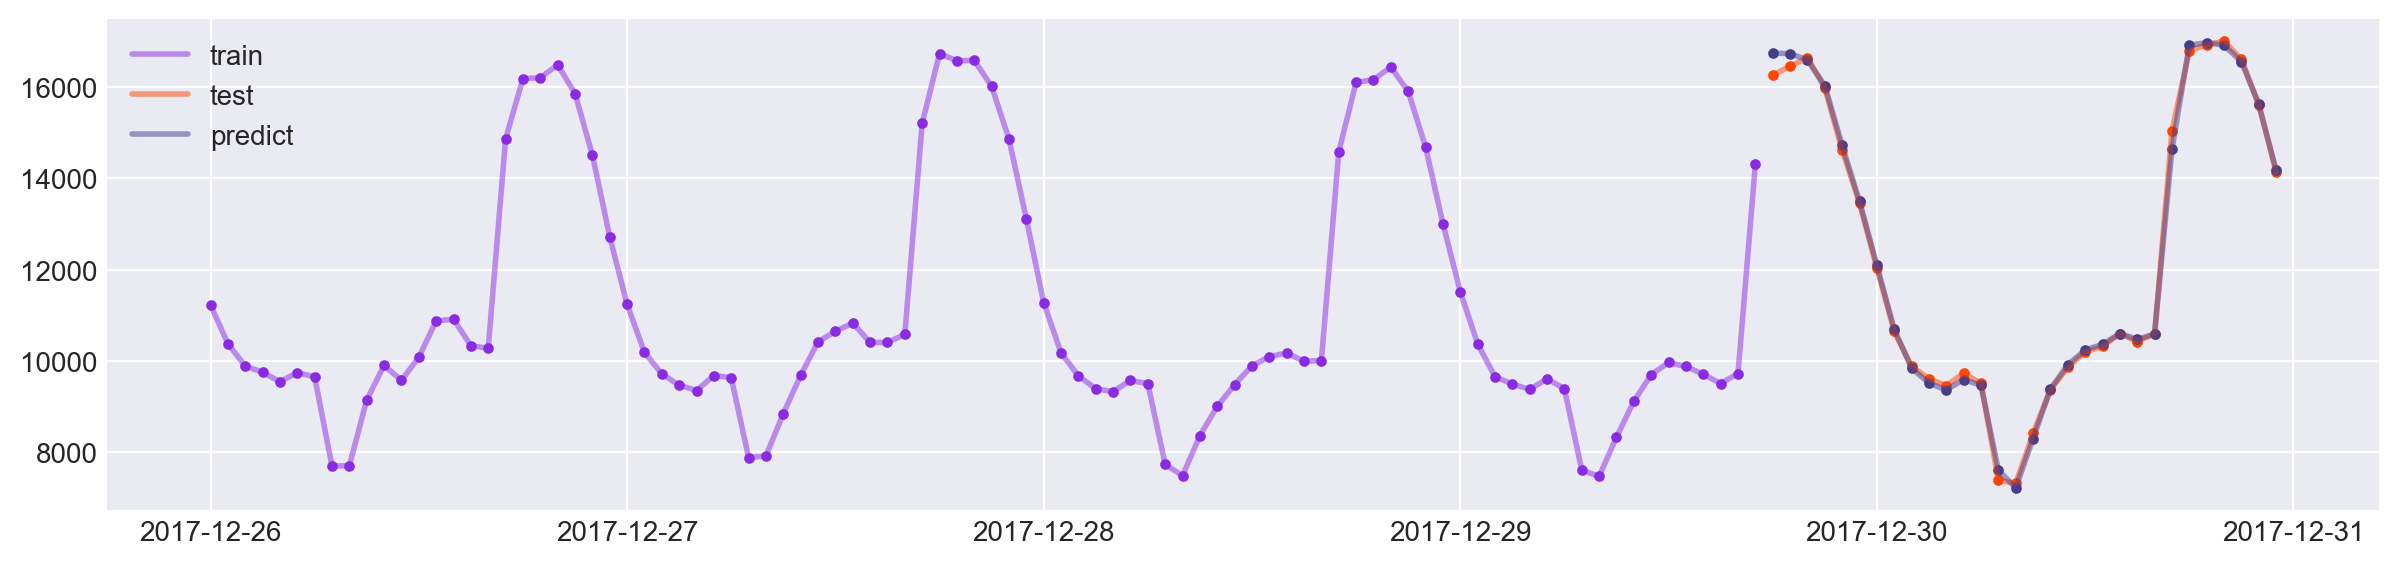

In [14]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### Random Forest Regressor

In [16]:
%%time

from sklearn.ensemble import RandomForestRegressor


model, yhat, model_name = None, None, None

model_name = "RandomForestRegressor"

# Best Params {'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 500}

param_grid = {
    #'bootstrap': [True,False],
    # "max_depth": [7, 8, 9],
    # "min_samples_leaf": [2, 3],
    # "min_samples_split": [7, 8],
    # "n_estimators": [300, 500, 600],
    "max_depth": [9],
    "min_samples_leaf": [2],
    "min_samples_split": [7],
    "n_estimators": [500],
}

estimator_ = RandomForestRegressor(random_state=80)


cross_validator = TimeSeriesSplit(n_splits=3)

gsearch = GridSearchCV(
    estimator=estimator_,
    cv=cross_validator,
    param_grid=param_grid,
    refit=True,
    verbose=3,
    n_jobs=1,
)

# gsearch.fit(train_x_scaled, train_y.to_numpy().flatten())


gsearch.fit(train_x, train_y.to_numpy().flatten())

print(gsearch.best_score_, gsearch.best_params_)

model = gsearch.best_estimator_

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[target_column].to_numpy(), yhat)
predictionsDF[model_name] = yhat

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END max_depth=9, min_samples_leaf=2, min_samples_split=7, n_estimators=500;, score=0.927 total time= 1.2min
[CV 2/3] END max_depth=9, min_samples_leaf=2, min_samples_split=7, n_estimators=500;, score=0.883 total time= 1.7min
[CV 3/3] END max_depth=9, min_samples_leaf=2, min_samples_split=7, n_estimators=500;, score=0.921 total time= 1.3min
0.9100881652874077 {'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 500}
CPU times: total: 1min 24s
Wall time: 5min 22s


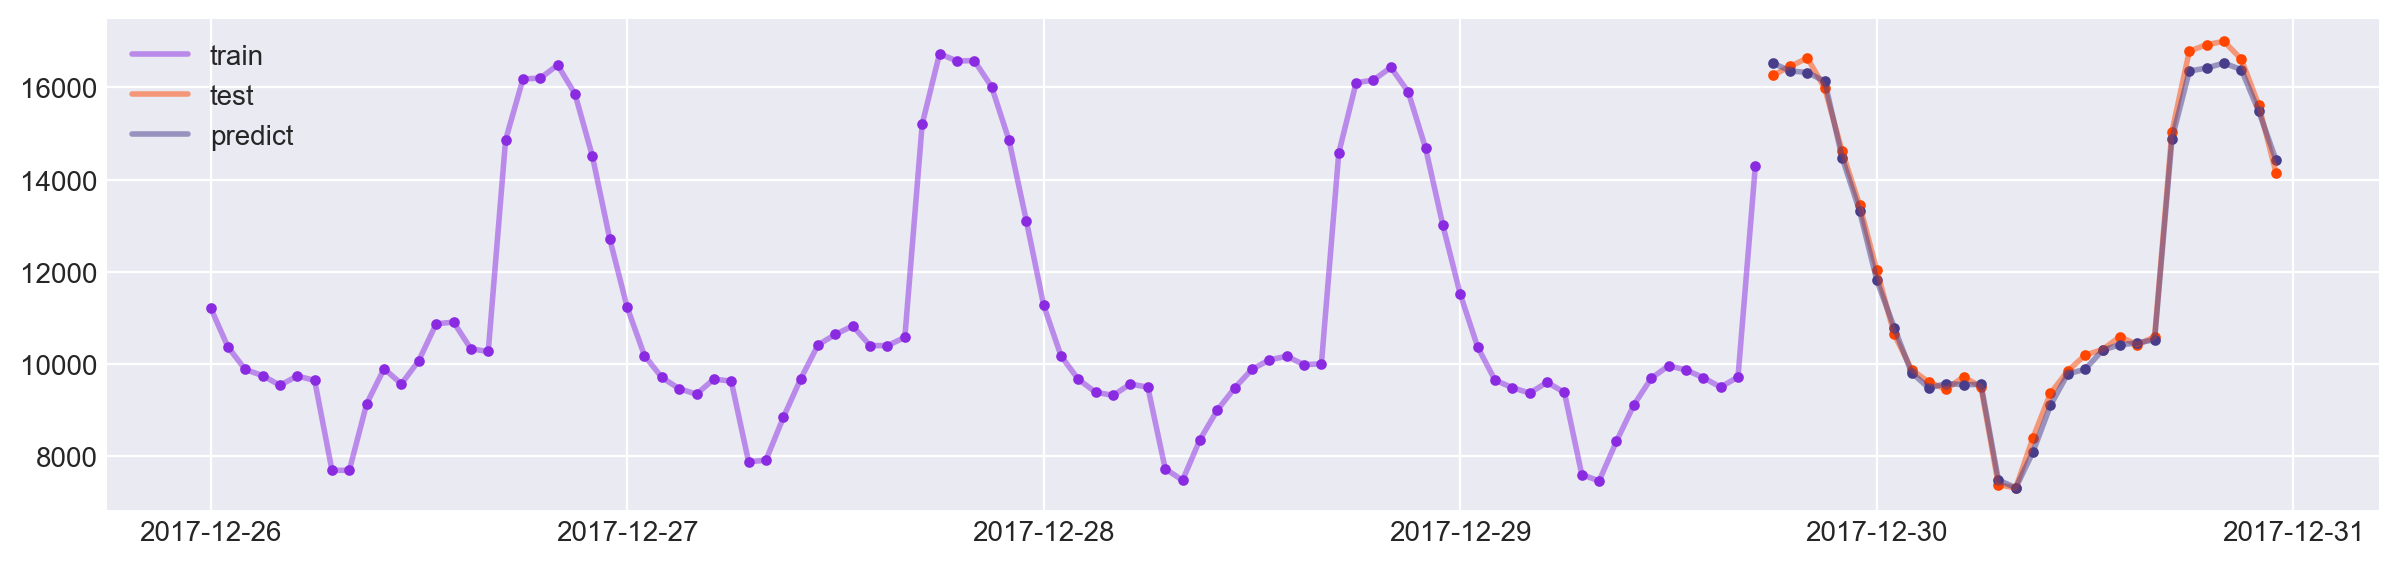

In [17]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### XGB Regressor

CPU times: total: 0 ns
Wall time: 0 ns
[0]	validation_0-mae:17675.78311	validation_1-mae:12238.98867
[1]	validation_0-mae:17499.66424	validation_1-mae:12117.76224
[2]	validation_0-mae:17325.27904	validation_1-mae:11997.32021
[3]	validation_0-mae:17152.64250	validation_1-mae:11878.00252
[4]	validation_0-mae:16981.74311	validation_1-mae:11760.06903
[5]	validation_0-mae:16812.50672	validation_1-mae:11643.02547
[6]	validation_0-mae:16645.00090	validation_1-mae:11528.01878
[7]	validation_0-mae:16479.14560	validation_1-mae:11413.03481
[8]	validation_0-mae:16314.96851	validation_1-mae:11299.17122
[9]	validation_0-mae:16152.37251	validation_1-mae:11186.97850
[10]	validation_0-mae:15991.47057	validation_1-mae:11075.25762
[11]	validation_0-mae:15832.13338	validation_1-mae:10965.69771
[12]	validation_0-mae:15674.38705	validation_1-mae:10855.56821
[13]	validation_0-mae:15518.26578	validation_1-mae:10746.60275
[14]	validation_0-mae:15363.63186	validation_1-mae:10640.37598
[15]	validation_0-mae:1521

[133]	validation_0-mae:4672.78087	validation_1-mae:3238.68905
[134]	validation_0-mae:4626.31421	validation_1-mae:3206.61717
[135]	validation_0-mae:4580.31475	validation_1-mae:3174.71427
[136]	validation_0-mae:4534.76997	validation_1-mae:3142.88934
[137]	validation_0-mae:4489.67520	validation_1-mae:3111.11117
[138]	validation_0-mae:4445.04882	validation_1-mae:3080.90713
[139]	validation_0-mae:4400.84337	validation_1-mae:3050.16434
[140]	validation_0-mae:4357.09199	validation_1-mae:3019.36934
[141]	validation_0-mae:4313.75556	validation_1-mae:2989.28714
[142]	validation_0-mae:4270.86695	validation_1-mae:2958.44601
[143]	validation_0-mae:4228.40045	validation_1-mae:2929.47586
[144]	validation_0-mae:4186.36190	validation_1-mae:2901.08739
[145]	validation_0-mae:4144.72584	validation_1-mae:2872.36380
[146]	validation_0-mae:4103.54054	validation_1-mae:2844.22254
[147]	validation_0-mae:4062.74783	validation_1-mae:2815.46213
[148]	validation_0-mae:4022.34439	validation_1-mae:2787.15830
[149]	va

[266]	validation_0-mae:1240.50348	validation_1-mae:859.19606
[267]	validation_0-mae:1228.28696	validation_1-mae:851.11182
[268]	validation_0-mae:1216.19855	validation_1-mae:842.60638
[269]	validation_0-mae:1204.22676	validation_1-mae:834.87360
[270]	validation_0-mae:1192.37671	validation_1-mae:827.01655
[271]	validation_0-mae:1180.65561	validation_1-mae:818.97000
[272]	validation_0-mae:1169.06156	validation_1-mae:811.39294
[273]	validation_0-mae:1157.56746	validation_1-mae:803.42450
[274]	validation_0-mae:1146.21478	validation_1-mae:795.89561
[275]	validation_0-mae:1134.95943	validation_1-mae:787.88965
[276]	validation_0-mae:1123.81721	validation_1-mae:779.97638
[277]	validation_0-mae:1112.78515	validation_1-mae:773.22503
[278]	validation_0-mae:1101.87336	validation_1-mae:765.62316
[279]	validation_0-mae:1091.08036	validation_1-mae:758.55767
[280]	validation_0-mae:1080.39305	validation_1-mae:751.94040
[281]	validation_0-mae:1069.80088	validation_1-mae:744.74867
[282]	validation_0-mae:1

[402]	validation_0-mae:363.80495	validation_1-mae:291.59979
[403]	validation_0-mae:361.23931	validation_1-mae:290.06608
[404]	validation_0-mae:358.70409	validation_1-mae:288.30042
[405]	validation_0-mae:356.21644	validation_1-mae:286.68289
[406]	validation_0-mae:353.74825	validation_1-mae:285.37443
[407]	validation_0-mae:351.33751	validation_1-mae:283.88807
[408]	validation_0-mae:348.92115	validation_1-mae:282.51984
[409]	validation_0-mae:346.57003	validation_1-mae:281.06873
[410]	validation_0-mae:344.23220	validation_1-mae:279.68006
[411]	validation_0-mae:341.92030	validation_1-mae:278.50591
[412]	validation_0-mae:339.66726	validation_1-mae:277.06483
[413]	validation_0-mae:337.43989	validation_1-mae:275.97616
[414]	validation_0-mae:335.27574	validation_1-mae:274.69933
[415]	validation_0-mae:333.10565	validation_1-mae:273.42795
[416]	validation_0-mae:330.95625	validation_1-mae:272.18553
[417]	validation_0-mae:328.83635	validation_1-mae:270.88008
[418]	validation_0-mae:326.76991	validat

[539]	validation_0-mae:206.63680	validation_1-mae:196.14017
[540]	validation_0-mae:206.22726	validation_1-mae:195.98971
[541]	validation_0-mae:205.87249	validation_1-mae:195.98988
[542]	validation_0-mae:205.49329	validation_1-mae:195.48953
[543]	validation_0-mae:205.08402	validation_1-mae:195.34089
[544]	validation_0-mae:204.64278	validation_1-mae:195.28698
[545]	validation_0-mae:204.27286	validation_1-mae:195.29323
[546]	validation_0-mae:203.90638	validation_1-mae:195.14284
[547]	validation_0-mae:203.58724	validation_1-mae:194.83278
[548]	validation_0-mae:203.22988	validation_1-mae:194.76104
[549]	validation_0-mae:202.88822	validation_1-mae:194.77184
[550]	validation_0-mae:202.54755	validation_1-mae:194.78271
[551]	validation_0-mae:202.19608	validation_1-mae:194.57988
[552]	validation_0-mae:201.77438	validation_1-mae:194.27386
[553]	validation_0-mae:201.46133	validation_1-mae:193.93455
[554]	validation_0-mae:201.11963	validation_1-mae:193.65057
[555]	validation_0-mae:200.72675	validat

[676]	validation_0-mae:177.34143	validation_1-mae:176.68128
[677]	validation_0-mae:177.26043	validation_1-mae:176.61436
[678]	validation_0-mae:177.18689	validation_1-mae:176.51592
[679]	validation_0-mae:177.07907	validation_1-mae:176.48778
[680]	validation_0-mae:176.97644	validation_1-mae:176.35151
[681]	validation_0-mae:176.81666	validation_1-mae:176.39090
[682]	validation_0-mae:176.74560	validation_1-mae:176.29663
[683]	validation_0-mae:176.65022	validation_1-mae:176.16193
[684]	validation_0-mae:176.53245	validation_1-mae:176.16873
[685]	validation_0-mae:176.46901	validation_1-mae:176.06369
[686]	validation_0-mae:176.39449	validation_1-mae:176.00441
[687]	validation_0-mae:176.29253	validation_1-mae:175.95311
[688]	validation_0-mae:176.13805	validation_1-mae:175.97879
[689]	validation_0-mae:176.04654	validation_1-mae:175.71515
[690]	validation_0-mae:175.89401	validation_1-mae:175.74113
[691]	validation_0-mae:175.82632	validation_1-mae:175.53553
[692]	validation_0-mae:175.76270	validat

[812]	validation_0-mae:163.04595	validation_1-mae:168.67090
[813]	validation_0-mae:162.99032	validation_1-mae:168.51839
[814]	validation_0-mae:162.95573	validation_1-mae:168.46243
[815]	validation_0-mae:162.87319	validation_1-mae:168.43844
[816]	validation_0-mae:162.78488	validation_1-mae:168.41592
[817]	validation_0-mae:162.73391	validation_1-mae:168.40091
[818]	validation_0-mae:162.63019	validation_1-mae:168.31178
[819]	validation_0-mae:162.55176	validation_1-mae:168.29668
[820]	validation_0-mae:162.46925	validation_1-mae:168.28063
[821]	validation_0-mae:162.36851	validation_1-mae:168.30384
[822]	validation_0-mae:162.32084	validation_1-mae:168.25607
[823]	validation_0-mae:162.25617	validation_1-mae:168.13439
[824]	validation_0-mae:162.14164	validation_1-mae:168.08449
[825]	validation_0-mae:162.06584	validation_1-mae:168.07876
[826]	validation_0-mae:161.97138	validation_1-mae:168.10295
[827]	validation_0-mae:161.91697	validation_1-mae:168.07619
[828]	validation_0-mae:161.83865	validat

[949]	validation_0-mae:154.58563	validation_1-mae:163.19189
[950]	validation_0-mae:154.53802	validation_1-mae:163.22233
[951]	validation_0-mae:154.49895	validation_1-mae:163.22513
[952]	validation_0-mae:154.45895	validation_1-mae:163.19720
[953]	validation_0-mae:154.42644	validation_1-mae:163.11357
[954]	validation_0-mae:154.36830	validation_1-mae:163.09998
[955]	validation_0-mae:154.32005	validation_1-mae:163.13016
[956]	validation_0-mae:154.26408	validation_1-mae:163.11724
[957]	validation_0-mae:154.18907	validation_1-mae:162.98390
[958]	validation_0-mae:154.14122	validation_1-mae:162.95031
[959]	validation_0-mae:154.10805	validation_1-mae:162.92070
[960]	validation_0-mae:154.07081	validation_1-mae:162.92363
[961]	validation_0-mae:153.98962	validation_1-mae:162.95781
[962]	validation_0-mae:153.93411	validation_1-mae:162.94486
[963]	validation_0-mae:153.89654	validation_1-mae:162.94798
[964]	validation_0-mae:153.86651	validation_1-mae:162.84268
[965]	validation_0-mae:153.78658	validat

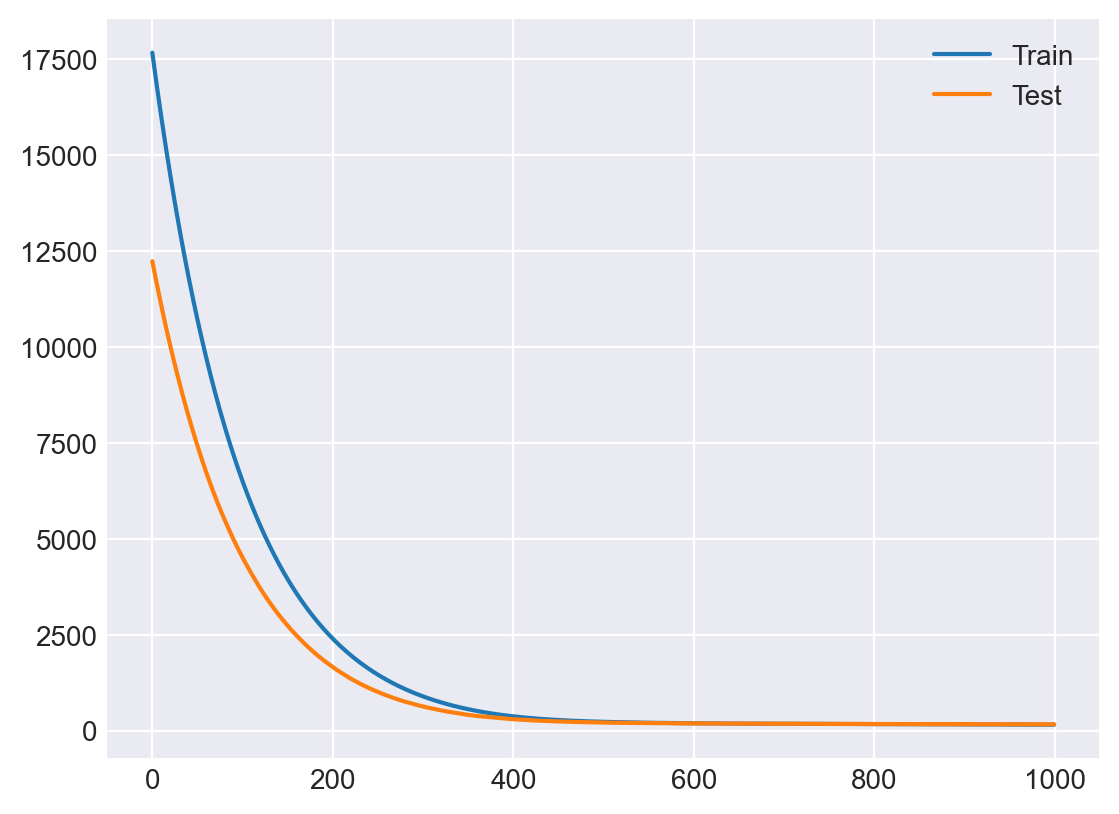

In [18]:
import xgboost as xgb

model, yhat, model_name = None, None, None

model_name = "XGBRegressor"

model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=1000,
    max_depth=6,
    learning_rate=0.01,
    tree_method="hist",
    early_stopping_rounds=20,
    eval_metric="mae",
    random_state=1,
)

%time

model.fit(
    train_x, train_y, eval_set=[(train_x, train_y), (test_x, test_y)], verbose=True
)

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[target_column].to_numpy(), yhat)

predictionsDF[model_name] = yhat

# resultsDF.head()

fig, ax = plt.subplots()
epochs = len(model.evals_result()["validation_0"]["mae"])
x_axis = range(0, epochs)
ax.plot(x_axis, model.evals_result()["validation_0"]["mae"], label="Train")
ax.plot(x_axis, model.evals_result()["validation_1"]["mae"], label="Test")
ax.legend()

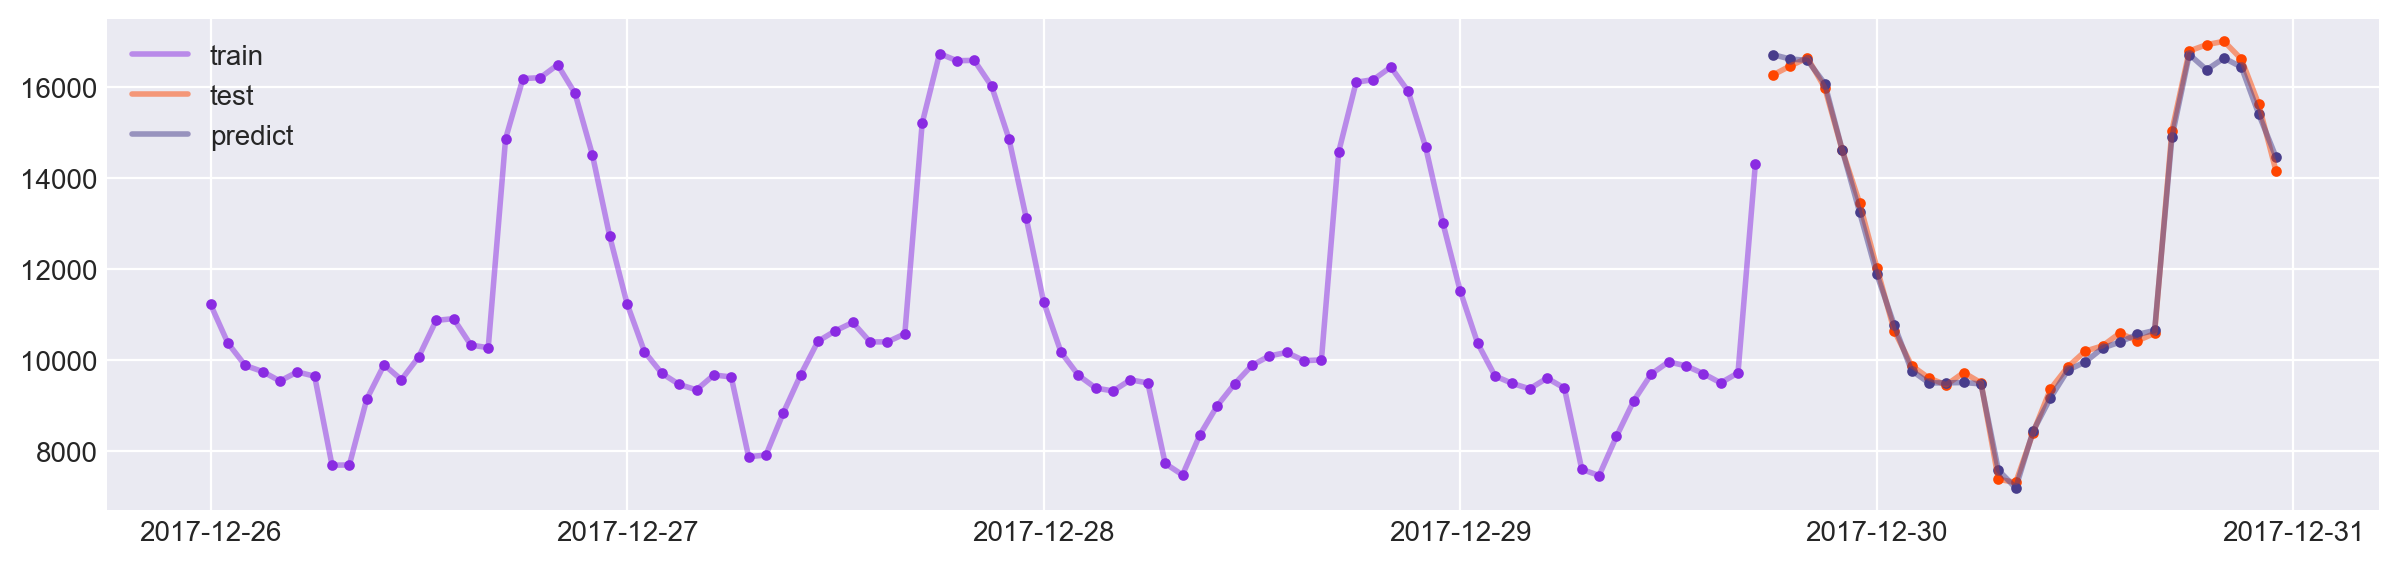

In [19]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### LGBM

In [20]:
import lightgbm as lgb

model, yhat, model_name = None, None, None

model_name = "LGBMRegressor"

hyper_params = {
    "task": "train",
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": ["mae", "l2"],
    "learning_rate": 0.005,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.7,
    "bagging_freq": 10,
    "verbose": 0,
    "max_depth": 8,
    "num_leaves": 128,
    "max_bin": 512,
    "num_iterations": 10000,
}

model = lgb.LGBMRegressor()

model.fit(
    train_x,
    train_y,
    eval_set=[(train_x, train_y), (test_x, test_y)],
    eval_metric="mae",
    callbacks=[lgb.early_stopping(stopping_rounds=5000), lgb.log_evaluation()],
)


yhat = model.predict(test_x, num_iteration=model.best_iteration_)

resultsDict[model_name] = evaluate(test_y[target_column].to_numpy(), yhat)

predictionsDF[model_name] = yhat

[1]	training's l1: 4657.25	training's l2: 3.54754e+07	valid_1's l1: 4943.6	valid_1's l2: 3.30432e+07
Training until validation scores don't improve for 5000 rounds
[2]	training's l1: 4205.91	training's l2: 2.90054e+07	valid_1's l1: 4456.49	valid_1's l2: 2.70121e+07
[3]	training's l1: 3795.46	training's l2: 2.37198e+07	valid_1's l1: 3987.42	valid_1's l2: 2.1937e+07
[4]	training's l1: 3428.4	training's l2: 1.94196e+07	valid_1's l1: 3598.91	valid_1's l2: 1.7968e+07
[5]	training's l1: 3098.34	training's l2: 1.59175e+07	valid_1's l1: 3215.83	valid_1's l2: 1.46057e+07
[6]	training's l1: 2803.87	training's l2: 1.30635e+07	valid_1's l1: 2916.15	valid_1's l2: 1.19467e+07
[7]	training's l1: 2536.47	training's l2: 1.07222e+07	valid_1's l1: 2640.39	valid_1's l2: 9.83877e+06
[8]	training's l1: 2295.23	training's l2: 8.81623e+06	valid_1's l1: 2385.95	valid_1's l2: 8.05026e+06
[9]	training's l1: 2080.9	training's l2: 7.25746e+06	valid_1's l1: 2153.81	valid_1's l2: 6.56418e+06
[10]	training's l1: 1884

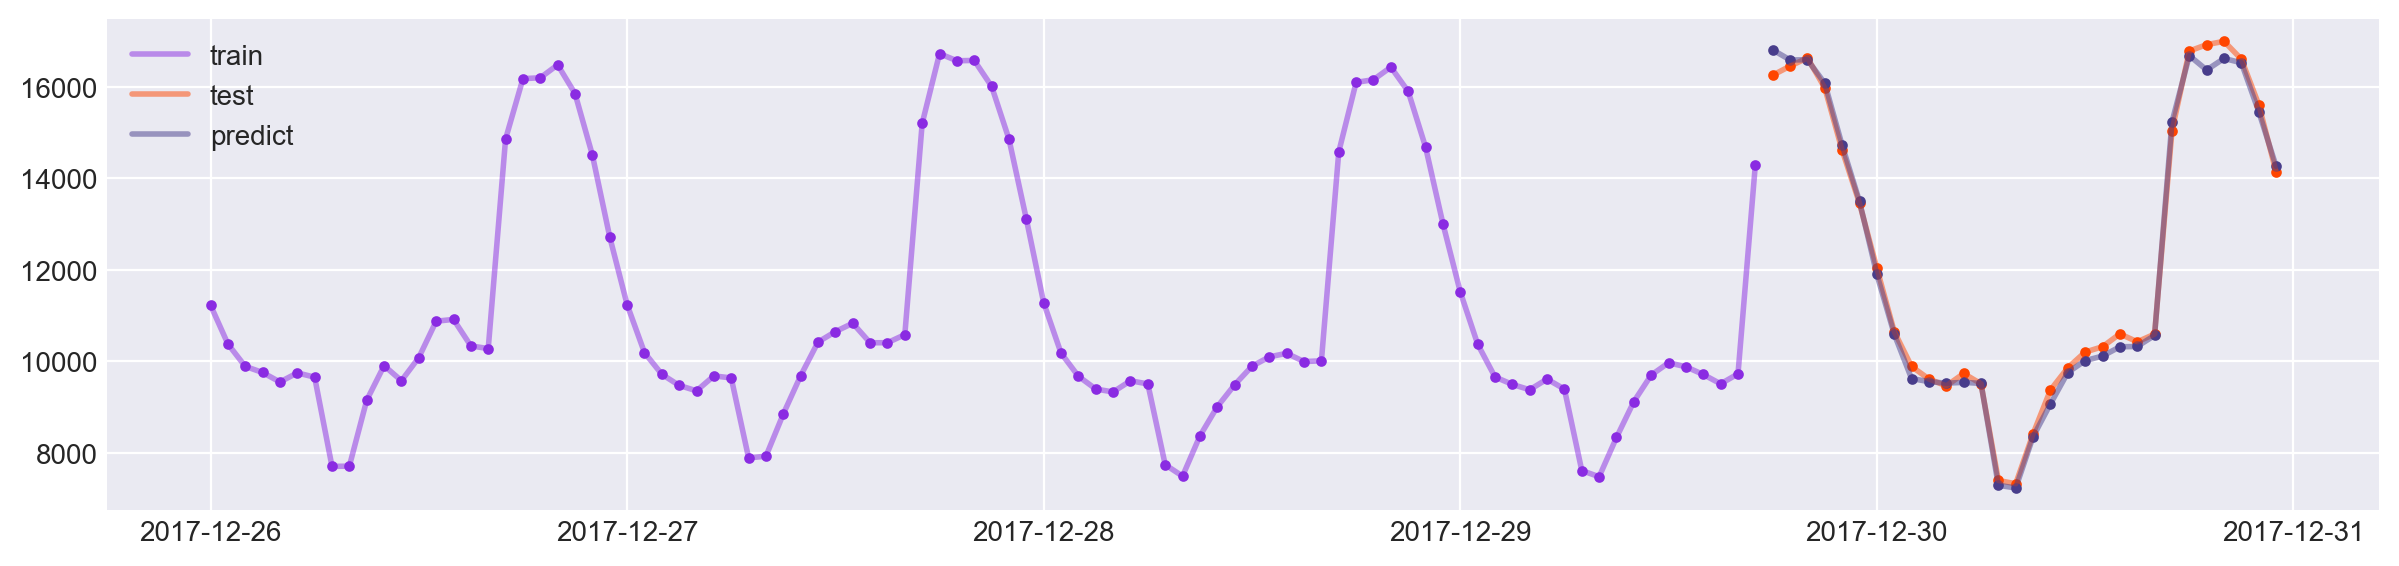

In [21]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### CatBoost

In [22]:
import catboost

model, yhat, model_name = None, None, None

model_name = "CatBoostRegressor"

model = catboost.CatBoostRegressor(learning_rate=0.1, depth=4, iterations=1000)

train_pool = catboost.Pool(train_x, train_y)
test_pool = catboost.Pool(test_x, test_y)

grid = {
    #    'learning_rate': [0.03, 0.1],
    #    'depth':[4, 6, 10],
    #    'l2_leaf_reg': [1, 3, 5, 7, 9]
    "l2_leaf_reg": [3, 5]
}

grid_search_results = model.grid_search(
    grid, train_pool, shuffle=False, verbose=3, refit=True, plot=False
)


print(grid_search_results["params"])

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[target_column].to_numpy(), yhat)

predictionsDF[model_name] = yhat

0:	learn: 18384.7167661	test: 11091.4012767	best: 11091.4012767 (0)	total: 149ms	remaining: 2m 28s
1:	learn: 16618.4133427	test: 9933.8732009	best: 9933.8732009 (1)	total: 158ms	remaining: 1m 18s
2:	learn: 15058.3494302	test: 8594.9244781	best: 8594.9244781 (2)	total: 175ms	remaining: 58.1s
3:	learn: 13628.0622624	test: 7482.8711338	best: 7482.8711338 (3)	total: 207ms	remaining: 51.6s
4:	learn: 12328.3124136	test: 6628.4308899	best: 6628.4308899 (4)	total: 237ms	remaining: 47.1s
5:	learn: 11175.3817851	test: 5732.9393404	best: 5732.9393404 (5)	total: 282ms	remaining: 46.7s
6:	learn: 10133.1622076	test: 4861.4833389	best: 4861.4833389 (6)	total: 340ms	remaining: 48.3s
7:	learn: 9213.2656658	test: 4223.3602912	best: 4223.3602912 (7)	total: 347ms	remaining: 43s
8:	learn: 8354.6180067	test: 3753.1176811	best: 3753.1176811 (8)	total: 381ms	remaining: 41.9s
9:	learn: 7578.6009824	test: 3418.5664824	best: 3418.5664824 (9)	total: 410ms	remaining: 40.5s
10:	learn: 6887.7076162	test: 3093.859173

87:	learn: 710.4300560	test: 1011.9287970	best: 1011.9287970 (87)	total: 3.3s	remaining: 34.3s
88:	learn: 706.4828245	test: 1011.3731885	best: 1011.3731885 (88)	total: 3.33s	remaining: 34.1s
89:	learn: 701.4419130	test: 1014.2831884	best: 1011.3731885 (88)	total: 3.35s	remaining: 33.9s
90:	learn: 697.8136061	test: 1005.6538660	best: 1005.6538660 (90)	total: 3.41s	remaining: 34.1s
91:	learn: 693.5296796	test: 1001.8254904	best: 1001.8254904 (91)	total: 3.46s	remaining: 34.2s
92:	learn: 689.7101211	test: 1001.1334385	best: 1001.1334385 (92)	total: 3.5s	remaining: 34.1s
93:	learn: 686.6959842	test: 985.8828552	best: 985.8828552 (93)	total: 3.52s	remaining: 33.9s
94:	learn: 683.8705966	test: 985.3590316	best: 985.3590316 (94)	total: 3.52s	remaining: 33.6s
95:	learn: 682.1263140	test: 971.2651272	best: 971.2651272 (95)	total: 3.53s	remaining: 33.2s
96:	learn: 679.7043326	test: 971.4056136	best: 971.2651272 (95)	total: 3.53s	remaining: 32.9s
97:	learn: 674.3368403	test: 970.6153426	best: 970

178:	learn: 528.5145892	test: 834.2825857	best: 834.2825857 (178)	total: 6.15s	remaining: 28.2s
179:	learn: 527.5308687	test: 834.0079078	best: 834.0079078 (179)	total: 6.2s	remaining: 28.3s
180:	learn: 526.1833396	test: 834.0347201	best: 834.0079078 (179)	total: 6.24s	remaining: 28.2s
181:	learn: 524.4864587	test: 834.1174555	best: 834.0079078 (179)	total: 6.27s	remaining: 28.2s
182:	learn: 523.0068040	test: 834.0512923	best: 834.0079078 (179)	total: 6.34s	remaining: 28.3s
183:	learn: 521.8005438	test: 833.7562154	best: 833.7562154 (183)	total: 6.39s	remaining: 28.4s
184:	learn: 520.3703456	test: 832.6622188	best: 832.6622188 (184)	total: 6.42s	remaining: 28.3s
185:	learn: 519.3192513	test: 830.9437660	best: 830.9437660 (185)	total: 6.47s	remaining: 28.3s
186:	learn: 518.4226532	test: 830.7201859	best: 830.7201859 (186)	total: 6.53s	remaining: 28.4s
187:	learn: 516.7025189	test: 829.8491742	best: 829.8491742 (187)	total: 6.58s	remaining: 28.4s
188:	learn: 515.1157992	test: 830.2741649

268:	learn: 450.0690106	test: 803.9121431	best: 803.9121431 (268)	total: 9.16s	remaining: 24.9s
269:	learn: 449.4389172	test: 802.6287149	best: 802.6287149 (269)	total: 9.23s	remaining: 25s
270:	learn: 448.4039802	test: 802.4939431	best: 802.4939431 (270)	total: 9.26s	remaining: 24.9s
271:	learn: 447.8519656	test: 800.7290780	best: 800.7290780 (271)	total: 9.3s	remaining: 24.9s
272:	learn: 447.3874567	test: 800.6170295	best: 800.6170295 (272)	total: 9.33s	remaining: 24.9s
273:	learn: 446.4852448	test: 800.5965502	best: 800.5965502 (273)	total: 9.42s	remaining: 25s
274:	learn: 445.6022348	test: 800.6491532	best: 800.5965502 (273)	total: 9.45s	remaining: 24.9s
275:	learn: 445.0396617	test: 801.0392312	best: 800.5965502 (273)	total: 9.5s	remaining: 24.9s
276:	learn: 444.2319860	test: 801.1979158	best: 800.5965502 (273)	total: 9.56s	remaining: 25s
277:	learn: 443.5834949	test: 803.1905411	best: 800.5965502 (273)	total: 9.6s	remaining: 24.9s
278:	learn: 442.8566511	test: 803.1658802	best: 8

363:	learn: 399.1100211	test: 802.3325629	best: 799.9854184 (352)	total: 12.7s	remaining: 22.2s
364:	learn: 398.7102499	test: 802.3747896	best: 799.9854184 (352)	total: 12.8s	remaining: 22.2s
365:	learn: 398.1703949	test: 802.4275281	best: 799.9854184 (352)	total: 12.8s	remaining: 22.2s
366:	learn: 397.8589614	test: 802.4138270	best: 799.9854184 (352)	total: 12.8s	remaining: 22.1s
367:	learn: 397.4032021	test: 802.9629799	best: 799.9854184 (352)	total: 12.9s	remaining: 22.1s
368:	learn: 397.1693485	test: 802.9300729	best: 799.9854184 (352)	total: 12.9s	remaining: 22.1s
369:	learn: 396.7390952	test: 802.6763227	best: 799.9854184 (352)	total: 12.9s	remaining: 22s
370:	learn: 396.4693933	test: 802.7479530	best: 799.9854184 (352)	total: 12.9s	remaining: 21.9s
371:	learn: 396.1095589	test: 804.1583396	best: 799.9854184 (352)	total: 13s	remaining: 21.9s
372:	learn: 395.7377258	test: 802.9435270	best: 799.9854184 (352)	total: 13s	remaining: 21.8s
373:	learn: 395.4273149	test: 802.6604587	best

455:	learn: 366.0903961	test: 794.7627899	best: 793.8059523 (452)	total: 15.4s	remaining: 18.4s
456:	learn: 365.4380448	test: 794.6500473	best: 793.8059523 (452)	total: 15.5s	remaining: 18.4s
457:	learn: 364.8185354	test: 794.7702623	best: 793.8059523 (452)	total: 15.5s	remaining: 18.4s
458:	learn: 364.5134439	test: 794.8891772	best: 793.8059523 (452)	total: 15.6s	remaining: 18.3s
459:	learn: 364.1803153	test: 794.8053831	best: 793.8059523 (452)	total: 15.6s	remaining: 18.3s
460:	learn: 363.7730290	test: 794.9276807	best: 793.8059523 (452)	total: 15.6s	remaining: 18.3s
461:	learn: 363.1974823	test: 794.8523155	best: 793.8059523 (452)	total: 15.7s	remaining: 18.3s
462:	learn: 362.8850439	test: 794.2800352	best: 793.8059523 (452)	total: 15.7s	remaining: 18.2s
463:	learn: 362.6722502	test: 794.3029939	best: 793.8059523 (452)	total: 15.8s	remaining: 18.2s
464:	learn: 362.3531881	test: 794.3287859	best: 793.8059523 (452)	total: 15.8s	remaining: 18.2s
465:	learn: 362.0639832	test: 793.620712

546:	learn: 336.7220413	test: 790.4797251	best: 790.2463643 (543)	total: 18.6s	remaining: 15.4s
547:	learn: 336.5426613	test: 790.4892307	best: 790.2463643 (543)	total: 18.6s	remaining: 15.3s
548:	learn: 336.1282283	test: 790.5370312	best: 790.2463643 (543)	total: 18.6s	remaining: 15.3s
549:	learn: 335.8673226	test: 790.5599832	best: 790.2463643 (543)	total: 18.6s	remaining: 15.2s
550:	learn: 335.5923967	test: 790.3320452	best: 790.2463643 (543)	total: 18.6s	remaining: 15.2s
551:	learn: 335.3084465	test: 790.2996028	best: 790.2463643 (543)	total: 18.6s	remaining: 15.1s
552:	learn: 335.0775430	test: 790.1467595	best: 790.1467595 (552)	total: 18.7s	remaining: 15.1s
553:	learn: 334.7835035	test: 789.5737824	best: 789.5737824 (553)	total: 18.7s	remaining: 15.1s
554:	learn: 334.5241822	test: 789.4432718	best: 789.4432718 (554)	total: 18.8s	remaining: 15.1s
555:	learn: 334.3528102	test: 789.5584189	best: 789.4432718 (554)	total: 18.8s	remaining: 15s
556:	learn: 334.0129750	test: 789.6561602	

635:	learn: 314.7047166	test: 781.8708080	best: 781.3925991 (628)	total: 21.8s	remaining: 12.4s
636:	learn: 314.4935987	test: 781.8496281	best: 781.3925991 (628)	total: 21.8s	remaining: 12.4s
637:	learn: 314.2881303	test: 781.7061639	best: 781.3925991 (628)	total: 21.8s	remaining: 12.4s
638:	learn: 314.0188880	test: 780.9861319	best: 780.9861319 (638)	total: 21.9s	remaining: 12.3s
639:	learn: 313.8166649	test: 779.6236578	best: 779.6236578 (639)	total: 21.9s	remaining: 12.3s
640:	learn: 313.5715656	test: 779.6046333	best: 779.6046333 (640)	total: 21.9s	remaining: 12.3s
641:	learn: 313.1305588	test: 779.4537853	best: 779.4537853 (641)	total: 22s	remaining: 12.3s
642:	learn: 312.9219705	test: 779.4802393	best: 779.4537853 (641)	total: 22s	remaining: 12.2s
643:	learn: 312.6677083	test: 779.2287633	best: 779.2287633 (643)	total: 22s	remaining: 12.2s
644:	learn: 312.4303636	test: 779.0873135	best: 779.0873135 (644)	total: 22s	remaining: 12.1s
645:	learn: 312.2470761	test: 779.1027295	best: 

723:	learn: 296.5161536	test: 769.0919243	best: 769.0919243 (723)	total: 24.1s	remaining: 9.2s
724:	learn: 296.2721592	test: 768.9749096	best: 768.9749096 (724)	total: 24.1s	remaining: 9.16s
725:	learn: 296.1177826	test: 768.8982277	best: 768.8982277 (725)	total: 24.1s	remaining: 9.11s
726:	learn: 295.9134217	test: 768.5527220	best: 768.5527220 (726)	total: 24.2s	remaining: 9.07s
727:	learn: 295.7541534	test: 768.5225393	best: 768.5225393 (727)	total: 24.2s	remaining: 9.03s
728:	learn: 295.5711075	test: 768.5887694	best: 768.5225393 (727)	total: 24.2s	remaining: 8.98s
729:	learn: 295.4865878	test: 766.6074409	best: 766.6074409 (729)	total: 24.2s	remaining: 8.94s
730:	learn: 295.4162591	test: 766.2885445	best: 766.2885445 (730)	total: 24.2s	remaining: 8.89s
731:	learn: 295.1671715	test: 766.1308242	best: 766.1308242 (731)	total: 24.2s	remaining: 8.86s
732:	learn: 294.9475381	test: 766.5669618	best: 766.1308242 (731)	total: 24.3s	remaining: 8.84s
733:	learn: 294.8144027	test: 766.5394653

811:	learn: 281.3540937	test: 757.9800220	best: 757.9800220 (811)	total: 26.6s	remaining: 6.16s
812:	learn: 281.1538241	test: 757.9762437	best: 757.9762437 (812)	total: 26.6s	remaining: 6.12s
813:	learn: 281.0433230	test: 757.7426330	best: 757.7426330 (813)	total: 26.6s	remaining: 6.08s
814:	learn: 280.7144309	test: 757.4621979	best: 757.4621979 (814)	total: 26.6s	remaining: 6.05s
815:	learn: 280.4307843	test: 757.1039978	best: 757.1039978 (815)	total: 26.7s	remaining: 6.01s
816:	learn: 280.2147451	test: 757.1315599	best: 757.1039978 (815)	total: 26.7s	remaining: 5.99s
817:	learn: 280.0210114	test: 757.3846217	best: 757.1039978 (815)	total: 26.8s	remaining: 5.96s
818:	learn: 279.7592532	test: 757.3816683	best: 757.1039978 (815)	total: 26.8s	remaining: 5.93s
819:	learn: 279.6403252	test: 757.5500445	best: 757.1039978 (815)	total: 26.8s	remaining: 5.89s
820:	learn: 279.5455908	test: 757.5095136	best: 757.1039978 (815)	total: 26.8s	remaining: 5.85s
821:	learn: 279.4468009	test: 757.629252

897:	learn: 267.0427358	test: 749.3744350	best: 749.3480537 (896)	total: 29.3s	remaining: 3.33s
898:	learn: 266.9070225	test: 749.2313955	best: 749.2313955 (898)	total: 29.3s	remaining: 3.3s
899:	learn: 266.6782654	test: 749.0288391	best: 749.0288391 (899)	total: 29.4s	remaining: 3.26s
900:	learn: 266.5955483	test: 748.9701595	best: 748.9701595 (900)	total: 29.4s	remaining: 3.23s
901:	learn: 266.4830999	test: 748.7547508	best: 748.7547508 (901)	total: 29.5s	remaining: 3.2s
902:	learn: 266.2450678	test: 748.7884814	best: 748.7547508 (901)	total: 29.5s	remaining: 3.17s
903:	learn: 266.1597906	test: 748.7298276	best: 748.7298276 (903)	total: 29.5s	remaining: 3.13s
904:	learn: 266.0371753	test: 748.1429958	best: 748.1429958 (904)	total: 29.5s	remaining: 3.1s
905:	learn: 265.7229313	test: 748.2289643	best: 748.1429958 (904)	total: 29.5s	remaining: 3.06s
906:	learn: 265.5555412	test: 747.9692845	best: 747.9692845 (906)	total: 29.6s	remaining: 3.03s
907:	learn: 265.3063154	test: 747.9903123	b

987:	learn: 254.0327198	test: 740.6238744	best: 740.6087230 (986)	total: 32.2s	remaining: 391ms
988:	learn: 253.9389177	test: 740.1940298	best: 740.1940298 (988)	total: 32.2s	remaining: 358ms
989:	learn: 253.8155413	test: 740.2253729	best: 740.1940298 (988)	total: 32.2s	remaining: 325ms
990:	learn: 253.7073481	test: 739.8993389	best: 739.8993389 (990)	total: 32.2s	remaining: 293ms
991:	learn: 253.6110922	test: 739.9214887	best: 739.8993389 (990)	total: 32.2s	remaining: 260ms
992:	learn: 253.4959519	test: 739.9618772	best: 739.8993389 (990)	total: 32.2s	remaining: 227ms
993:	learn: 253.3112840	test: 739.9075071	best: 739.8993389 (990)	total: 32.2s	remaining: 195ms
994:	learn: 253.1515106	test: 739.7740788	best: 739.7740788 (994)	total: 32.2s	remaining: 162ms
995:	learn: 253.0585846	test: 739.5011458	best: 739.5011458 (995)	total: 32.2s	remaining: 129ms
996:	learn: 252.8678998	test: 739.6174826	best: 739.5011458 (995)	total: 32.3s	remaining: 97ms
997:	learn: 252.6923841	test: 739.6137712

77:	learn: 782.3093307	test: 1103.1871004	best: 1103.1871004 (77)	total: 2.19s	remaining: 25.9s
78:	learn: 776.1525118	test: 1100.8197767	best: 1100.8197767 (78)	total: 2.19s	remaining: 25.6s
79:	learn: 769.4896412	test: 1099.6340770	best: 1099.6340770 (79)	total: 2.2s	remaining: 25.3s
80:	learn: 762.5543923	test: 1093.0919972	best: 1093.0919972 (80)	total: 2.2s	remaining: 25s
81:	learn: 760.0030624	test: 1080.0996756	best: 1080.0996756 (81)	total: 2.21s	remaining: 24.7s
82:	learn: 757.8505951	test: 1073.8851780	best: 1073.8851780 (82)	total: 2.21s	remaining: 24.5s
83:	learn: 755.2968988	test: 1072.5027441	best: 1072.5027441 (83)	total: 2.22s	remaining: 24.2s
84:	learn: 751.2371267	test: 1069.5639132	best: 1069.5639132 (84)	total: 2.24s	remaining: 24.2s
85:	learn: 746.9464994	test: 1071.3567319	best: 1069.5639132 (84)	total: 2.3s	remaining: 24.5s
86:	learn: 742.9281277	test: 1059.0764045	best: 1059.0764045 (86)	total: 2.34s	remaining: 24.5s
87:	learn: 737.3474669	test: 1061.3558245	bes

164:	learn: 554.3600216	test: 1001.5653257	best: 999.2589909 (163)	total: 4.87s	remaining: 24.7s
165:	learn: 553.4312508	test: 1000.5032264	best: 999.2589909 (163)	total: 4.88s	remaining: 24.5s
166:	learn: 551.5824721	test: 1000.0127958	best: 999.2589909 (163)	total: 4.88s	remaining: 24.4s
167:	learn: 549.3813192	test: 1000.0535057	best: 999.2589909 (163)	total: 4.89s	remaining: 24.2s
168:	learn: 548.6292758	test: 1002.7925313	best: 999.2589909 (163)	total: 4.9s	remaining: 24.1s
169:	learn: 547.9129040	test: 1000.6729472	best: 999.2589909 (163)	total: 4.91s	remaining: 24s
170:	learn: 546.9112801	test: 998.2535700	best: 998.2535700 (170)	total: 4.92s	remaining: 23.8s
171:	learn: 545.7277594	test: 996.3940834	best: 996.3940834 (171)	total: 4.97s	remaining: 23.9s
172:	learn: 543.4448384	test: 996.5257395	best: 996.3940834 (171)	total: 5.01s	remaining: 23.9s
173:	learn: 541.9887732	test: 996.1928107	best: 996.1928107 (173)	total: 5.04s	remaining: 23.9s
174:	learn: 541.1198547	test: 994.889

262:	learn: 463.6026942	test: 995.9542274	best: 981.1608990 (202)	total: 7.15s	remaining: 20s
263:	learn: 463.0793436	test: 996.4862626	best: 981.1608990 (202)	total: 7.16s	remaining: 20s
264:	learn: 462.6120759	test: 996.0779527	best: 981.1608990 (202)	total: 7.16s	remaining: 19.9s
265:	learn: 461.9206168	test: 1000.5580256	best: 981.1608990 (202)	total: 7.17s	remaining: 19.8s
266:	learn: 461.4029386	test: 1000.3273575	best: 981.1608990 (202)	total: 7.18s	remaining: 19.7s
267:	learn: 460.7764224	test: 1001.0252780	best: 981.1608990 (202)	total: 7.24s	remaining: 19.8s
268:	learn: 460.1744677	test: 1001.0257212	best: 981.1608990 (202)	total: 7.29s	remaining: 19.8s
269:	learn: 459.3516557	test: 1000.2281948	best: 981.1608990 (202)	total: 7.33s	remaining: 19.8s
270:	learn: 458.2763724	test: 999.9975552	best: 981.1608990 (202)	total: 7.36s	remaining: 19.8s
271:	learn: 457.8904616	test: 999.8527867	best: 981.1608990 (202)	total: 7.36s	remaining: 19.7s
272:	learn: 457.4902056	test: 999.86166

349:	learn: 417.4911131	test: 993.5984170	best: 981.1608990 (202)	total: 9.34s	remaining: 17.3s
350:	learn: 417.1747500	test: 994.0287788	best: 981.1608990 (202)	total: 9.35s	remaining: 17.3s
351:	learn: 416.3662649	test: 994.1036426	best: 981.1608990 (202)	total: 9.39s	remaining: 17.3s
352:	learn: 415.8269195	test: 992.9845676	best: 981.1608990 (202)	total: 9.44s	remaining: 17.3s
353:	learn: 415.4389241	test: 992.5770349	best: 981.1608990 (202)	total: 9.48s	remaining: 17.3s
354:	learn: 415.1036068	test: 990.0864862	best: 981.1608990 (202)	total: 9.5s	remaining: 17.3s
355:	learn: 414.5292690	test: 989.0744344	best: 981.1608990 (202)	total: 9.59s	remaining: 17.3s
356:	learn: 414.0518302	test: 989.1846121	best: 981.1608990 (202)	total: 9.63s	remaining: 17.3s
357:	learn: 413.5762611	test: 989.5355924	best: 981.1608990 (202)	total: 9.66s	remaining: 17.3s
358:	learn: 413.2139468	test: 989.1408728	best: 981.1608990 (202)	total: 9.69s	remaining: 17.3s
359:	learn: 412.9028497	test: 989.6211280

442:	learn: 380.9218603	test: 988.1829680	best: 981.1608990 (202)	total: 11.9s	remaining: 14.9s
443:	learn: 380.5765032	test: 988.4245925	best: 981.1608990 (202)	total: 11.9s	remaining: 15s
444:	learn: 380.2601558	test: 988.2037133	best: 981.1608990 (202)	total: 12s	remaining: 14.9s
445:	learn: 380.0673863	test: 988.5926375	best: 981.1608990 (202)	total: 12s	remaining: 14.9s
446:	learn: 379.5284632	test: 988.9110005	best: 981.1608990 (202)	total: 12.1s	remaining: 14.9s
447:	learn: 379.2270817	test: 988.2279102	best: 981.1608990 (202)	total: 12.1s	remaining: 14.9s
448:	learn: 378.6115464	test: 990.5901718	best: 981.1608990 (202)	total: 12.1s	remaining: 14.9s
449:	learn: 378.2504330	test: 990.7191746	best: 981.1608990 (202)	total: 12.2s	remaining: 14.9s
450:	learn: 377.7996800	test: 991.2160198	best: 981.1608990 (202)	total: 12.2s	remaining: 14.8s
451:	learn: 377.3059174	test: 991.2567123	best: 981.1608990 (202)	total: 12.3s	remaining: 14.9s
452:	learn: 376.9676429	test: 990.3614862	best

533:	learn: 352.2554726	test: 994.5252818	best: 981.1608990 (202)	total: 14.3s	remaining: 12.5s
534:	learn: 352.0040552	test: 994.5069551	best: 981.1608990 (202)	total: 14.3s	remaining: 12.5s
535:	learn: 351.7508817	test: 993.4862000	best: 981.1608990 (202)	total: 14.4s	remaining: 12.5s
536:	learn: 351.3189290	test: 993.0326098	best: 981.1608990 (202)	total: 14.5s	remaining: 12.5s
537:	learn: 351.1554822	test: 993.0509872	best: 981.1608990 (202)	total: 14.5s	remaining: 12.4s
538:	learn: 350.8479831	test: 992.2947018	best: 981.1608990 (202)	total: 14.5s	remaining: 12.4s
539:	learn: 350.7692487	test: 992.6573182	best: 981.1608990 (202)	total: 14.6s	remaining: 12.4s
540:	learn: 350.5960690	test: 992.6161788	best: 981.1608990 (202)	total: 14.6s	remaining: 12.4s
541:	learn: 350.3322051	test: 992.5083737	best: 981.1608990 (202)	total: 14.7s	remaining: 12.4s
542:	learn: 349.9902395	test: 992.5752168	best: 981.1608990 (202)	total: 14.7s	remaining: 12.4s
543:	learn: 349.7576229	test: 992.729202

622:	learn: 329.5880261	test: 981.3828657	best: 981.1608990 (202)	total: 16.6s	remaining: 10s
623:	learn: 329.4703908	test: 981.3829769	best: 981.1608990 (202)	total: 16.6s	remaining: 10s
624:	learn: 329.3181122	test: 981.2446618	best: 981.1608990 (202)	total: 16.6s	remaining: 9.97s
625:	learn: 329.0548163	test: 981.3729469	best: 981.1608990 (202)	total: 16.6s	remaining: 9.93s
626:	learn: 328.6561847	test: 980.9497749	best: 980.9497749 (626)	total: 16.6s	remaining: 9.89s
627:	learn: 328.3772640	test: 981.1071023	best: 980.9497749 (626)	total: 16.6s	remaining: 9.85s
628:	learn: 328.3248588	test: 981.0782778	best: 980.9497749 (626)	total: 16.6s	remaining: 9.81s
629:	learn: 328.0595279	test: 981.1818779	best: 980.9497749 (626)	total: 16.7s	remaining: 9.78s
630:	learn: 327.8059048	test: 981.1448745	best: 980.9497749 (626)	total: 16.7s	remaining: 9.78s
631:	learn: 327.5313987	test: 981.4617971	best: 980.9497749 (626)	total: 16.8s	remaining: 9.77s
632:	learn: 327.3127801	test: 981.3536508	be

709:	learn: 310.7319978	test: 976.9609147	best: 976.9609147 (709)	total: 18.8s	remaining: 7.67s
710:	learn: 310.4323667	test: 977.2143090	best: 976.9609147 (709)	total: 18.8s	remaining: 7.63s
711:	learn: 310.1809968	test: 977.3780138	best: 976.9609147 (709)	total: 18.8s	remaining: 7.59s
712:	learn: 310.0247062	test: 977.3376115	best: 976.9609147 (709)	total: 18.8s	remaining: 7.56s
713:	learn: 309.6831264	test: 976.4085212	best: 976.4085212 (713)	total: 18.8s	remaining: 7.53s
714:	learn: 309.4573337	test: 975.8967822	best: 975.8967822 (714)	total: 18.8s	remaining: 7.49s
715:	learn: 309.1992424	test: 976.0219574	best: 975.8967822 (714)	total: 18.8s	remaining: 7.46s
716:	learn: 309.0501278	test: 976.2556010	best: 975.8967822 (714)	total: 18.8s	remaining: 7.42s
717:	learn: 308.8146749	test: 976.1427037	best: 975.8967822 (714)	total: 18.8s	remaining: 7.39s
718:	learn: 308.5791788	test: 976.1747968	best: 975.8967822 (714)	total: 18.8s	remaining: 7.35s
719:	learn: 308.4366743	test: 976.110553

804:	learn: 293.0095164	test: 965.6188501	best: 965.5158818 (798)	total: 21s	remaining: 5.09s
805:	learn: 292.8349710	test: 965.9651869	best: 965.5158818 (798)	total: 21s	remaining: 5.06s
806:	learn: 292.7387981	test: 965.7835572	best: 965.5158818 (798)	total: 21.1s	remaining: 5.04s
807:	learn: 292.5803849	test: 965.5707452	best: 965.5158818 (798)	total: 21.1s	remaining: 5.01s
808:	learn: 292.3444887	test: 966.5670463	best: 965.5158818 (798)	total: 21.2s	remaining: 5s
809:	learn: 292.2222065	test: 966.6006979	best: 965.5158818 (798)	total: 21.2s	remaining: 4.98s
810:	learn: 292.1828569	test: 966.7497462	best: 965.5158818 (798)	total: 21.3s	remaining: 4.95s
811:	learn: 291.9198152	test: 965.9252106	best: 965.5158818 (798)	total: 21.3s	remaining: 4.93s
812:	learn: 291.7496322	test: 965.8345229	best: 965.5158818 (798)	total: 21.3s	remaining: 4.91s
813:	learn: 291.6616288	test: 965.6680212	best: 965.5158818 (798)	total: 21.4s	remaining: 4.89s
814:	learn: 291.5799580	test: 965.3697138	best:

895:	learn: 278.0541664	test: 956.4690921	best: 956.0350698 (891)	total: 23.4s	remaining: 2.72s
896:	learn: 277.9473738	test: 955.2012194	best: 955.2012194 (896)	total: 23.5s	remaining: 2.69s
897:	learn: 277.7977153	test: 955.1929371	best: 955.1929371 (897)	total: 23.5s	remaining: 2.67s
898:	learn: 277.6242175	test: 955.1128654	best: 955.1128654 (898)	total: 23.5s	remaining: 2.64s
899:	learn: 277.3911763	test: 954.5732281	best: 954.5732281 (899)	total: 23.5s	remaining: 2.61s
900:	learn: 277.2914333	test: 955.0246322	best: 954.5732281 (899)	total: 23.5s	remaining: 2.59s
901:	learn: 277.1300397	test: 955.3496963	best: 954.5732281 (899)	total: 23.6s	remaining: 2.56s
902:	learn: 277.0448255	test: 954.4336276	best: 954.4336276 (902)	total: 23.6s	remaining: 2.54s
903:	learn: 276.8175343	test: 954.4160948	best: 954.4160948 (903)	total: 23.6s	remaining: 2.51s
904:	learn: 276.5938950	test: 952.5914678	best: 952.5914678 (904)	total: 23.7s	remaining: 2.48s
905:	learn: 276.3851240	test: 952.597513

984:	learn: 264.9681429	test: 948.2261701	best: 948.2261701 (984)	total: 26.1s	remaining: 397ms
985:	learn: 264.8669144	test: 948.3938038	best: 948.2261701 (984)	total: 26.2s	remaining: 371ms
986:	learn: 264.7242568	test: 948.4970913	best: 948.2261701 (984)	total: 26.2s	remaining: 345ms
987:	learn: 264.5765520	test: 948.5464126	best: 948.2261701 (984)	total: 26.2s	remaining: 318ms
988:	learn: 264.4320082	test: 948.5132421	best: 948.2261701 (984)	total: 26.3s	remaining: 292ms
989:	learn: 264.2745397	test: 948.6419172	best: 948.2261701 (984)	total: 26.3s	remaining: 266ms
990:	learn: 264.1522920	test: 948.4925684	best: 948.2261701 (984)	total: 26.3s	remaining: 239ms
991:	learn: 263.9778866	test: 948.5703734	best: 948.2261701 (984)	total: 26.4s	remaining: 213ms
992:	learn: 263.7959977	test: 947.1322177	best: 947.1322177 (992)	total: 26.4s	remaining: 186ms
993:	learn: 263.7067967	test: 947.1284064	best: 947.1284064 (993)	total: 26.4s	remaining: 159ms
994:	learn: 263.5714180	test: 947.124246

68:	learn: 780.5232928	test: 1649.3325179	best: 1641.6764236 (63)	total: 1.88s	remaining: 25.3s
69:	learn: 776.9495933	test: 1647.6484475	best: 1641.6764236 (63)	total: 1.95s	remaining: 25.8s
70:	learn: 769.9345283	test: 1646.9213916	best: 1641.6764236 (63)	total: 1.98s	remaining: 25.9s
71:	learn: 767.0148832	test: 1649.1731035	best: 1641.6764236 (63)	total: 2.02s	remaining: 26s
72:	learn: 763.4247301	test: 1649.2549922	best: 1641.6764236 (63)	total: 2.05s	remaining: 26s
73:	learn: 759.5348504	test: 1638.5090172	best: 1638.5090172 (73)	total: 2.13s	remaining: 26.6s
74:	learn: 755.8516270	test: 1634.0709776	best: 1634.0709776 (74)	total: 2.16s	remaining: 26.7s
75:	learn: 748.5018636	test: 1629.6385134	best: 1629.6385134 (75)	total: 2.2s	remaining: 26.7s
76:	learn: 745.9769575	test: 1628.3594297	best: 1628.3594297 (76)	total: 2.23s	remaining: 26.7s
77:	learn: 741.6946016	test: 1627.1980937	best: 1627.1980937 (77)	total: 2.3s	remaining: 27.2s
78:	learn: 736.2683458	test: 1624.6817383	best

154:	learn: 554.9664967	test: 1512.9670958	best: 1511.2761213 (148)	total: 4.49s	remaining: 24.5s
155:	learn: 553.8548922	test: 1508.7875448	best: 1508.7875448 (155)	total: 4.49s	remaining: 24.3s
156:	learn: 552.0454640	test: 1508.2163509	best: 1508.2163509 (156)	total: 4.5s	remaining: 24.1s
157:	learn: 550.5893455	test: 1504.0034046	best: 1504.0034046 (157)	total: 4.5s	remaining: 24s
158:	learn: 548.9887311	test: 1504.2493342	best: 1504.0034046 (157)	total: 4.5s	remaining: 23.8s
159:	learn: 548.0453100	test: 1504.3463016	best: 1504.0034046 (157)	total: 4.51s	remaining: 23.7s
160:	learn: 546.5310485	test: 1503.4287662	best: 1503.4287662 (160)	total: 4.58s	remaining: 23.9s
161:	learn: 545.8013784	test: 1499.9794644	best: 1499.9794644 (161)	total: 4.63s	remaining: 23.9s
162:	learn: 544.0627824	test: 1500.5233817	best: 1499.9794644 (161)	total: 4.66s	remaining: 23.9s
163:	learn: 542.9310787	test: 1498.8221900	best: 1498.8221900 (163)	total: 4.68s	remaining: 23.9s
164:	learn: 541.6726720	t

239:	learn: 472.1387532	test: 1412.5279298	best: 1412.5279298 (239)	total: 6.7s	remaining: 21.2s
240:	learn: 471.2880143	test: 1409.0805722	best: 1409.0805722 (240)	total: 6.76s	remaining: 21.3s
241:	learn: 470.3037607	test: 1409.0981473	best: 1409.0805722 (240)	total: 6.79s	remaining: 21.3s
242:	learn: 470.0076816	test: 1409.4854804	best: 1409.0805722 (240)	total: 6.82s	remaining: 21.3s
243:	learn: 469.4573814	test: 1399.2821195	best: 1399.2821195 (243)	total: 6.86s	remaining: 21.3s
244:	learn: 468.6127404	test: 1404.3637901	best: 1399.2821195 (243)	total: 6.92s	remaining: 21.3s
245:	learn: 467.7086044	test: 1403.7086090	best: 1399.2821195 (243)	total: 6.96s	remaining: 21.3s
246:	learn: 466.8024150	test: 1398.7670901	best: 1398.7670901 (246)	total: 6.99s	remaining: 21.3s
247:	learn: 466.2298183	test: 1392.3743405	best: 1392.3743405 (247)	total: 7.02s	remaining: 21.3s
248:	learn: 465.5892323	test: 1392.0103556	best: 1392.0103556 (248)	total: 7.02s	remaining: 21.2s
249:	learn: 465.01753

334:	learn: 414.6802948	test: 1353.4911026	best: 1353.4911026 (334)	total: 9.2s	remaining: 18.3s
335:	learn: 414.1066710	test: 1352.6927814	best: 1352.6927814 (335)	total: 9.25s	remaining: 18.3s
336:	learn: 413.5322202	test: 1353.1536054	best: 1352.6927814 (335)	total: 9.28s	remaining: 18.3s
337:	learn: 413.0982421	test: 1351.7597427	best: 1351.7597427 (337)	total: 9.34s	remaining: 18.3s
338:	learn: 412.8552157	test: 1351.7036773	best: 1351.7036773 (338)	total: 9.39s	remaining: 18.3s
339:	learn: 412.4730048	test: 1350.4240195	best: 1350.4240195 (339)	total: 9.43s	remaining: 18.3s
340:	learn: 412.0022181	test: 1350.9310045	best: 1350.4240195 (339)	total: 9.45s	remaining: 18.3s
341:	learn: 411.5627451	test: 1349.9762138	best: 1349.9762138 (341)	total: 9.51s	remaining: 18.3s
342:	learn: 411.0195468	test: 1350.6634871	best: 1349.9762138 (341)	total: 9.57s	remaining: 18.3s
343:	learn: 410.7230803	test: 1350.5113813	best: 1349.9762138 (341)	total: 9.61s	remaining: 18.3s
344:	learn: 410.29955

421:	learn: 378.1206078	test: 1322.8308553	best: 1322.8308553 (421)	total: 11.8s	remaining: 16.2s
422:	learn: 377.7578640	test: 1322.8833731	best: 1322.8308553 (421)	total: 11.8s	remaining: 16.1s
423:	learn: 377.4952617	test: 1322.8038679	best: 1322.8038679 (423)	total: 11.9s	remaining: 16.1s
424:	learn: 377.1834876	test: 1322.5552937	best: 1322.5552937 (424)	total: 11.9s	remaining: 16.1s
425:	learn: 376.8426220	test: 1322.7094993	best: 1322.5552937 (424)	total: 12s	remaining: 16.1s
426:	learn: 376.6821858	test: 1322.6398375	best: 1322.5552937 (424)	total: 12s	remaining: 16.1s
427:	learn: 376.2886442	test: 1322.1185596	best: 1322.1185596 (427)	total: 12s	remaining: 16.1s
428:	learn: 376.1028569	test: 1322.5991145	best: 1322.1185596 (427)	total: 12s	remaining: 16s
429:	learn: 375.8419492	test: 1322.7189843	best: 1322.1185596 (427)	total: 12.1s	remaining: 16s
430:	learn: 375.4186197	test: 1322.0186645	best: 1322.0186645 (430)	total: 12.1s	remaining: 15.9s
431:	learn: 374.8983615	test: 13

511:	learn: 348.7291172	test: 1295.4088175	best: 1294.9685219 (504)	total: 13.9s	remaining: 13.3s
512:	learn: 348.4787880	test: 1295.1872170	best: 1294.9685219 (504)	total: 13.9s	remaining: 13.2s
513:	learn: 348.2139596	test: 1294.7498812	best: 1294.7498812 (513)	total: 14s	remaining: 13.2s
514:	learn: 347.9308042	test: 1294.1917415	best: 1294.1917415 (514)	total: 14s	remaining: 13.2s
515:	learn: 347.6361449	test: 1294.3273939	best: 1294.1917415 (514)	total: 14.1s	remaining: 13.2s
516:	learn: 347.4068463	test: 1293.7397867	best: 1293.7397867 (516)	total: 14.1s	remaining: 13.2s
517:	learn: 347.0885982	test: 1293.7394555	best: 1293.7394555 (517)	total: 14.1s	remaining: 13.2s
518:	learn: 346.9460256	test: 1293.5565773	best: 1293.5565773 (518)	total: 14.2s	remaining: 13.1s
519:	learn: 346.8223233	test: 1293.2932618	best: 1293.2932618 (519)	total: 14.2s	remaining: 13.1s
520:	learn: 346.5543226	test: 1293.9695218	best: 1293.2932618 (519)	total: 14.2s	remaining: 13s
521:	learn: 346.3020973	te

600:	learn: 325.4240080	test: 1272.9225109	best: 1272.9225109 (600)	total: 16.8s	remaining: 11.1s
601:	learn: 324.9974065	test: 1272.4541825	best: 1272.4541825 (601)	total: 16.8s	remaining: 11.1s
602:	learn: 324.7546847	test: 1272.3383737	best: 1272.3383737 (602)	total: 16.9s	remaining: 11.1s
603:	learn: 324.3054307	test: 1272.1462685	best: 1272.1462685 (603)	total: 16.9s	remaining: 11.1s
604:	learn: 324.0563752	test: 1271.6246356	best: 1271.6246356 (604)	total: 16.9s	remaining: 11s
605:	learn: 323.7532717	test: 1271.5971665	best: 1271.5971665 (605)	total: 16.9s	remaining: 11s
606:	learn: 323.5476018	test: 1271.9609614	best: 1271.5971665 (605)	total: 17s	remaining: 11s
607:	learn: 323.2489425	test: 1271.8278147	best: 1271.5971665 (605)	total: 17s	remaining: 10.9s
608:	learn: 323.0440415	test: 1269.2364561	best: 1269.2364561 (608)	total: 17s	remaining: 10.9s
609:	learn: 322.7672535	test: 1269.2848559	best: 1269.2364561 (608)	total: 17.1s	remaining: 10.9s
610:	learn: 322.4055106	test: 12

692:	learn: 303.8863886	test: 1260.1086107	best: 1259.2815757 (686)	total: 19.5s	remaining: 8.63s
693:	learn: 303.7466819	test: 1260.1853232	best: 1259.2815757 (686)	total: 19.5s	remaining: 8.59s
694:	learn: 303.4898195	test: 1259.6972430	best: 1259.2815757 (686)	total: 19.5s	remaining: 8.55s
695:	learn: 303.2973854	test: 1260.1220778	best: 1259.2815757 (686)	total: 19.5s	remaining: 8.51s
696:	learn: 303.1382559	test: 1259.8950215	best: 1259.2815757 (686)	total: 19.5s	remaining: 8.47s
697:	learn: 303.0117936	test: 1260.0488446	best: 1259.2815757 (686)	total: 19.6s	remaining: 8.46s
698:	learn: 302.6519893	test: 1260.0038680	best: 1259.2815757 (686)	total: 19.6s	remaining: 8.43s
699:	learn: 302.4621994	test: 1260.3909946	best: 1259.2815757 (686)	total: 19.6s	remaining: 8.4s
700:	learn: 302.2712167	test: 1260.7602878	best: 1259.2815757 (686)	total: 19.6s	remaining: 8.38s
701:	learn: 301.8891239	test: 1257.9360880	best: 1257.9360880 (701)	total: 19.7s	remaining: 8.35s
702:	learn: 301.70648

778:	learn: 287.5107572	test: 1238.9320301	best: 1238.8373907 (774)	total: 22.1s	remaining: 6.26s
779:	learn: 287.3841011	test: 1239.2982841	best: 1238.8373907 (774)	total: 22.1s	remaining: 6.23s
780:	learn: 287.1928587	test: 1239.2496565	best: 1238.8373907 (774)	total: 22.1s	remaining: 6.19s
781:	learn: 287.0011747	test: 1238.8999934	best: 1238.8373907 (774)	total: 22.1s	remaining: 6.16s
782:	learn: 286.7590602	test: 1238.6135401	best: 1238.6135401 (782)	total: 22.1s	remaining: 6.12s
783:	learn: 286.6689632	test: 1237.8034964	best: 1237.8034964 (783)	total: 22.1s	remaining: 6.09s
784:	learn: 286.4679964	test: 1237.4774296	best: 1237.4774296 (784)	total: 22.2s	remaining: 6.07s
785:	learn: 286.3288314	test: 1237.5515547	best: 1237.4774296 (784)	total: 22.2s	remaining: 6.04s
786:	learn: 286.1432639	test: 1237.3729026	best: 1237.3729026 (786)	total: 22.2s	remaining: 6.02s
787:	learn: 285.9878030	test: 1237.4049122	best: 1237.3729026 (786)	total: 22.3s	remaining: 6s
788:	learn: 285.8399163

865:	learn: 271.0557167	test: 1232.1448694	best: 1232.1448694 (865)	total: 24.1s	remaining: 3.72s
866:	learn: 270.9111705	test: 1232.3582090	best: 1232.1448694 (865)	total: 24.1s	remaining: 3.69s
867:	learn: 270.7601771	test: 1232.4001076	best: 1232.1448694 (865)	total: 24.1s	remaining: 3.66s
868:	learn: 270.4603364	test: 1232.5786058	best: 1232.1448694 (865)	total: 24.1s	remaining: 3.63s
869:	learn: 270.1953023	test: 1231.7163547	best: 1231.7163547 (869)	total: 24.1s	remaining: 3.6s
870:	learn: 270.0185676	test: 1232.1146544	best: 1231.7163547 (869)	total: 24.1s	remaining: 3.56s
871:	learn: 269.8237657	test: 1231.9491683	best: 1231.7163547 (869)	total: 24.1s	remaining: 3.53s
872:	learn: 269.6466894	test: 1231.8553038	best: 1231.7163547 (869)	total: 24.1s	remaining: 3.5s
873:	learn: 269.5355600	test: 1231.9614691	best: 1231.7163547 (869)	total: 24.1s	remaining: 3.47s
874:	learn: 269.3137083	test: 1231.9828161	best: 1231.7163547 (869)	total: 24.1s	remaining: 3.44s
875:	learn: 269.117286

958:	learn: 255.4361837	test: 1222.0759402	best: 1222.0759402 (958)	total: 26.1s	remaining: 1.11s
959:	learn: 255.3376401	test: 1222.0615258	best: 1222.0615258 (959)	total: 26.1s	remaining: 1.09s
960:	learn: 255.1272525	test: 1221.9593135	best: 1221.9593135 (960)	total: 26.1s	remaining: 1.06s
961:	learn: 255.0007564	test: 1222.1943881	best: 1221.9593135 (960)	total: 26.1s	remaining: 1.03s
962:	learn: 254.7106407	test: 1222.1975507	best: 1221.9593135 (960)	total: 26.1s	remaining: 1s
963:	learn: 254.6051252	test: 1222.2215369	best: 1221.9593135 (960)	total: 26.1s	remaining: 975ms
964:	learn: 254.5325818	test: 1222.1681347	best: 1221.9593135 (960)	total: 26.1s	remaining: 947ms
965:	learn: 254.2128983	test: 1221.8886486	best: 1221.8886486 (965)	total: 26.1s	remaining: 920ms
966:	learn: 254.1414656	test: 1221.8886138	best: 1221.8886138 (966)	total: 26.1s	remaining: 892ms
967:	learn: 253.9921880	test: 1221.9333583	best: 1221.8886138 (966)	total: 26.2s	remaining: 865ms
968:	learn: 253.7918594

45:	learn: 784.0728416	test: 5413.5559377	best: 5413.5559377 (45)	total: 1.5s	remaining: 31.2s
46:	learn: 766.9790402	test: 5384.9854237	best: 5384.9854237 (46)	total: 1.51s	remaining: 30.6s
47:	learn: 757.9256481	test: 5366.3660099	best: 5366.3660099 (47)	total: 1.51s	remaining: 30s
48:	learn: 750.3797570	test: 5343.9066288	best: 5343.9066288 (48)	total: 1.52s	remaining: 29.4s
49:	learn: 737.2591073	test: 5326.6970444	best: 5326.6970444 (49)	total: 1.52s	remaining: 28.9s
50:	learn: 723.7114299	test: 5293.6191174	best: 5293.6191174 (50)	total: 1.52s	remaining: 28.4s
51:	learn: 710.9151489	test: 5281.4549078	best: 5281.4549078 (51)	total: 1.53s	remaining: 27.9s
52:	learn: 704.3156654	test: 5268.9273710	best: 5268.9273710 (52)	total: 1.53s	remaining: 27.4s
53:	learn: 699.5991552	test: 5238.4044410	best: 5238.4044410 (53)	total: 1.53s	remaining: 26.9s
54:	learn: 689.3858237	test: 5227.9836996	best: 5227.9836996 (54)	total: 1.54s	remaining: 26.4s
55:	learn: 683.9699232	test: 5201.9141842	b

134:	learn: 473.3659202	test: 4704.0542106	best: 4701.1803889 (129)	total: 4s	remaining: 25.6s
135:	learn: 472.2541756	test: 4704.0059133	best: 4701.1803889 (129)	total: 4.04s	remaining: 25.7s
136:	learn: 471.2400065	test: 4701.2188521	best: 4701.1803889 (129)	total: 4.08s	remaining: 25.7s
137:	learn: 469.2327340	test: 4699.3494429	best: 4699.3494429 (137)	total: 4.11s	remaining: 25.7s
138:	learn: 468.2978594	test: 4692.7083536	best: 4692.7083536 (138)	total: 4.16s	remaining: 25.8s
139:	learn: 466.5541066	test: 4688.0164151	best: 4688.0164151 (139)	total: 4.21s	remaining: 25.9s
140:	learn: 465.1547560	test: 4688.3672921	best: 4688.0164151 (139)	total: 4.25s	remaining: 25.9s
141:	learn: 463.8386864	test: 4687.6309838	best: 4687.6309838 (141)	total: 4.29s	remaining: 25.9s
142:	learn: 462.4088866	test: 4686.6993570	best: 4686.6993570 (142)	total: 4.3s	remaining: 25.8s
143:	learn: 460.6927940	test: 4671.9638853	best: 4671.9638853 (143)	total: 4.33s	remaining: 25.7s
144:	learn: 459.2638116	

229:	learn: 384.5278431	test: 4516.0690219	best: 4516.0690219 (229)	total: 5.96s	remaining: 19.9s
230:	learn: 383.6471705	test: 4517.0218557	best: 4516.0690219 (229)	total: 5.96s	remaining: 19.8s
231:	learn: 382.9979019	test: 4517.0631743	best: 4516.0690219 (229)	total: 5.97s	remaining: 19.8s
232:	learn: 382.3676166	test: 4514.3644889	best: 4514.3644889 (232)	total: 5.99s	remaining: 19.7s
233:	learn: 381.6304119	test: 4514.7265475	best: 4514.3644889 (232)	total: 6.01s	remaining: 19.7s
234:	learn: 381.0678069	test: 4516.9364471	best: 4514.3644889 (232)	total: 6.03s	remaining: 19.6s
235:	learn: 380.6490128	test: 4516.5842980	best: 4514.3644889 (232)	total: 6.05s	remaining: 19.6s
236:	learn: 380.2744229	test: 4517.5419538	best: 4514.3644889 (232)	total: 6.07s	remaining: 19.5s
237:	learn: 379.1954688	test: 4518.9211267	best: 4514.3644889 (232)	total: 6.09s	remaining: 19.5s
238:	learn: 378.1713227	test: 4518.8407857	best: 4514.3644889 (232)	total: 6.11s	remaining: 19.4s
239:	learn: 377.5220

318:	learn: 335.6584475	test: 4476.8367151	best: 4470.5964550 (313)	total: 7.98s	remaining: 17s
319:	learn: 335.0841052	test: 4477.5176563	best: 4470.5964550 (313)	total: 7.99s	remaining: 17s
320:	learn: 334.7042157	test: 4477.7077773	best: 4470.5964550 (313)	total: 7.99s	remaining: 16.9s
321:	learn: 334.3508973	test: 4478.8049753	best: 4470.5964550 (313)	total: 8s	remaining: 16.8s
322:	learn: 333.8213998	test: 4475.7918039	best: 4470.5964550 (313)	total: 8.07s	remaining: 16.9s
323:	learn: 333.5382097	test: 4474.9989071	best: 4470.5964550 (313)	total: 8.1s	remaining: 16.9s
324:	learn: 333.2915061	test: 4470.5705577	best: 4470.5705577 (324)	total: 8.13s	remaining: 16.9s
325:	learn: 332.7919255	test: 4480.3312460	best: 4470.5705577 (324)	total: 8.19s	remaining: 16.9s
326:	learn: 332.5525527	test: 4480.5527815	best: 4470.5705577 (324)	total: 8.23s	remaining: 16.9s
327:	learn: 332.0111927	test: 4479.0655322	best: 4470.5705577 (324)	total: 8.26s	remaining: 16.9s
328:	learn: 331.5144134	test

405:	learn: 302.2099148	test: 4459.6588417	best: 4457.0070020 (397)	total: 10.7s	remaining: 15.6s
406:	learn: 301.8758120	test: 4457.8743589	best: 4457.0070020 (397)	total: 10.7s	remaining: 15.5s
407:	learn: 301.7768361	test: 4457.8840994	best: 4457.0070020 (397)	total: 10.7s	remaining: 15.5s
408:	learn: 301.5355557	test: 4457.8704527	best: 4457.0070020 (397)	total: 10.7s	remaining: 15.4s
409:	learn: 301.2105376	test: 4457.8832433	best: 4457.0070020 (397)	total: 10.7s	remaining: 15.4s
410:	learn: 300.9816018	test: 4458.6292342	best: 4457.0070020 (397)	total: 10.7s	remaining: 15.3s
411:	learn: 300.7398476	test: 4459.7043180	best: 4457.0070020 (397)	total: 10.8s	remaining: 15.4s
412:	learn: 300.4806583	test: 4459.9516620	best: 4457.0070020 (397)	total: 10.8s	remaining: 15.3s
413:	learn: 300.1551239	test: 4461.2070201	best: 4457.0070020 (397)	total: 10.8s	remaining: 15.3s
414:	learn: 299.9096987	test: 4460.9265123	best: 4457.0070020 (397)	total: 10.8s	remaining: 15.3s
415:	learn: 299.6354

499:	learn: 274.1655384	test: 4420.1200734	best: 4406.1012976 (443)	total: 12.5s	remaining: 12.5s
500:	learn: 273.9573735	test: 4420.6553395	best: 4406.1012976 (443)	total: 12.6s	remaining: 12.5s
501:	learn: 273.6608450	test: 4419.8886340	best: 4406.1012976 (443)	total: 12.6s	remaining: 12.5s
502:	learn: 273.5396951	test: 4419.8019895	best: 4406.1012976 (443)	total: 12.6s	remaining: 12.4s
503:	learn: 273.1994479	test: 4419.2198481	best: 4406.1012976 (443)	total: 12.6s	remaining: 12.4s
504:	learn: 272.9299727	test: 4417.7426873	best: 4406.1012976 (443)	total: 12.6s	remaining: 12.4s
505:	learn: 272.7669969	test: 4415.2077133	best: 4406.1012976 (443)	total: 12.7s	remaining: 12.4s
506:	learn: 272.6092634	test: 4415.3861219	best: 4406.1012976 (443)	total: 12.7s	remaining: 12.3s
507:	learn: 272.4776093	test: 4423.5282397	best: 4406.1012976 (443)	total: 12.7s	remaining: 12.3s
508:	learn: 272.1460704	test: 4423.4443623	best: 4406.1012976 (443)	total: 12.7s	remaining: 12.3s
509:	learn: 271.8675

585:	learn: 253.2943723	test: 4388.0569217	best: 4383.2357397 (569)	total: 14.3s	remaining: 10.1s
586:	learn: 253.1725374	test: 4386.6824210	best: 4383.2357397 (569)	total: 14.4s	remaining: 10.1s
587:	learn: 253.0266014	test: 4387.5979892	best: 4383.2357397 (569)	total: 14.4s	remaining: 10.1s
588:	learn: 252.8541994	test: 4386.4254737	best: 4383.2357397 (569)	total: 14.5s	remaining: 10.1s
589:	learn: 252.6135143	test: 4386.3985684	best: 4383.2357397 (569)	total: 14.5s	remaining: 10.1s
590:	learn: 252.2621398	test: 4385.2757453	best: 4383.2357397 (569)	total: 14.6s	remaining: 10.1s
591:	learn: 251.9485193	test: 4372.9392096	best: 4372.9392096 (591)	total: 14.6s	remaining: 10.1s
592:	learn: 251.8556393	test: 4378.2701213	best: 4372.9392096 (591)	total: 14.6s	remaining: 10s
593:	learn: 251.5820164	test: 4381.0029252	best: 4372.9392096 (591)	total: 14.6s	remaining: 9.99s
594:	learn: 251.2169837	test: 4380.7811619	best: 4372.9392096 (591)	total: 14.6s	remaining: 9.95s
595:	learn: 250.945365

669:	learn: 236.1710046	test: 4368.3231725	best: 4362.8252257 (649)	total: 16.9s	remaining: 8.31s
670:	learn: 236.0260738	test: 4367.7975397	best: 4362.8252257 (649)	total: 16.9s	remaining: 8.27s
671:	learn: 235.8949753	test: 4367.8485329	best: 4362.8252257 (649)	total: 16.9s	remaining: 8.24s
672:	learn: 235.7847372	test: 4367.9255636	best: 4362.8252257 (649)	total: 16.9s	remaining: 8.2s
673:	learn: 235.6157325	test: 4368.2172036	best: 4362.8252257 (649)	total: 16.9s	remaining: 8.17s
674:	learn: 235.3665784	test: 4368.1698803	best: 4362.8252257 (649)	total: 16.9s	remaining: 8.13s
675:	learn: 235.2442626	test: 4365.6996862	best: 4362.8252257 (649)	total: 16.9s	remaining: 8.1s
676:	learn: 235.0887627	test: 4365.6812422	best: 4362.8252257 (649)	total: 16.9s	remaining: 8.07s
677:	learn: 234.9510962	test: 4365.2280416	best: 4362.8252257 (649)	total: 17s	remaining: 8.05s
678:	learn: 234.8028793	test: 4365.9150606	best: 4362.8252257 (649)	total: 17s	remaining: 8.06s
679:	learn: 234.5705358	te

764:	learn: 221.3208156	test: 4352.9347418	best: 4348.1417133 (761)	total: 18.4s	remaining: 5.66s
765:	learn: 221.1429240	test: 4353.1704975	best: 4348.1417133 (761)	total: 18.4s	remaining: 5.63s
766:	learn: 221.0306681	test: 4354.5937844	best: 4348.1417133 (761)	total: 18.4s	remaining: 5.6s
767:	learn: 220.8771231	test: 4354.6502596	best: 4348.1417133 (761)	total: 18.5s	remaining: 5.57s
768:	learn: 220.6392878	test: 4354.6255553	best: 4348.1417133 (761)	total: 18.5s	remaining: 5.56s
769:	learn: 220.4403923	test: 4354.2492392	best: 4348.1417133 (761)	total: 18.6s	remaining: 5.54s
770:	learn: 220.2897168	test: 4349.4341337	best: 4348.1417133 (761)	total: 18.6s	remaining: 5.52s
771:	learn: 220.2152250	test: 4349.3699124	best: 4348.1417133 (761)	total: 18.6s	remaining: 5.5s
772:	learn: 220.0365725	test: 4348.9943032	best: 4348.1417133 (761)	total: 18.7s	remaining: 5.49s
773:	learn: 219.9158005	test: 4349.0869087	best: 4348.1417133 (761)	total: 18.7s	remaining: 5.46s
774:	learn: 219.810453

859:	learn: 206.4013492	test: 4323.5463022	best: 4323.3950862 (856)	total: 21s	remaining: 3.42s
860:	learn: 206.3219052	test: 4323.0291536	best: 4323.0291536 (860)	total: 21.1s	remaining: 3.4s
861:	learn: 206.1024201	test: 4323.0100325	best: 4323.0100325 (861)	total: 21.1s	remaining: 3.38s
862:	learn: 206.0291939	test: 4323.0195570	best: 4323.0100325 (861)	total: 21.1s	remaining: 3.35s
863:	learn: 205.9135147	test: 4317.4094722	best: 4317.4094722 (863)	total: 21.2s	remaining: 3.34s
864:	learn: 205.8261709	test: 4317.4612830	best: 4317.4094722 (863)	total: 21.3s	remaining: 3.32s
865:	learn: 205.7287269	test: 4317.2614784	best: 4317.2614784 (865)	total: 21.3s	remaining: 3.3s
866:	learn: 205.6497074	test: 4317.1235434	best: 4317.1235434 (866)	total: 21.4s	remaining: 3.28s
867:	learn: 205.5632917	test: 4317.0552832	best: 4317.0552832 (867)	total: 21.4s	remaining: 3.26s
868:	learn: 205.4061749	test: 4317.1091008	best: 4317.0552832 (867)	total: 21.4s	remaining: 3.23s
869:	learn: 205.2941542	

948:	learn: 195.0146276	test: 4295.5019246	best: 4295.5019246 (948)	total: 23.7s	remaining: 1.27s
949:	learn: 194.9394399	test: 4295.3149456	best: 4295.3149456 (949)	total: 23.7s	remaining: 1.25s
950:	learn: 194.7907786	test: 4295.1578793	best: 4295.1578793 (950)	total: 23.7s	remaining: 1.22s
951:	learn: 194.6856857	test: 4294.8110661	best: 4294.8110661 (951)	total: 23.8s	remaining: 1.2s
952:	learn: 194.5970449	test: 4294.7479370	best: 4294.7479370 (952)	total: 23.8s	remaining: 1.18s
953:	learn: 194.5387421	test: 4294.8410195	best: 4294.7479370 (952)	total: 23.9s	remaining: 1.15s
954:	learn: 194.3691278	test: 4294.6931969	best: 4294.6931969 (954)	total: 24s	remaining: 1.13s
955:	learn: 194.2462499	test: 4294.4663187	best: 4294.4663187 (955)	total: 24s	remaining: 1.11s
956:	learn: 194.1159270	test: 4293.9615676	best: 4293.9615676 (956)	total: 24.1s	remaining: 1.08s
957:	learn: 193.9247126	test: 4293.9626489	best: 4293.9615676 (956)	total: 24.1s	remaining: 1.06s
958:	learn: 193.8377687	t

35:	learn: 1309.2373304	test: 2976.7274833	best: 2228.8527409 (15)	total: 1.07s	remaining: 28.8s
36:	learn: 1272.8449489	test: 2965.3478100	best: 2228.8527409 (15)	total: 1.14s	remaining: 29.6s
37:	learn: 1240.2666235	test: 2952.8067194	best: 2228.8527409 (15)	total: 1.2s	remaining: 30.4s
38:	learn: 1211.5026385	test: 2945.4769089	best: 2228.8527409 (15)	total: 1.26s	remaining: 31s
39:	learn: 1177.2549045	test: 2928.8441489	best: 2228.8527409 (15)	total: 1.31s	remaining: 31.5s
40:	learn: 1154.7623621	test: 2943.6938292	best: 2228.8527409 (15)	total: 1.34s	remaining: 31.3s
41:	learn: 1135.6151223	test: 2939.7059094	best: 2228.8527409 (15)	total: 1.38s	remaining: 31.5s
42:	learn: 1116.9620278	test: 2940.3996042	best: 2228.8527409 (15)	total: 1.42s	remaining: 31.7s
43:	learn: 1100.0864383	test: 2896.2077896	best: 2228.8527409 (15)	total: 1.46s	remaining: 31.6s
44:	learn: 1085.9366639	test: 2876.4010120	best: 2228.8527409 (15)	total: 1.49s	remaining: 31.6s
45:	learn: 1061.1773415	test: 287

128:	learn: 620.5589276	test: 2353.2458981	best: 2228.8527409 (15)	total: 4.35s	remaining: 29.4s
129:	learn: 618.0147200	test: 2352.9252909	best: 2228.8527409 (15)	total: 4.35s	remaining: 29.1s
130:	learn: 616.1282895	test: 2353.9340196	best: 2228.8527409 (15)	total: 4.36s	remaining: 28.9s
131:	learn: 614.0312163	test: 2347.3479346	best: 2228.8527409 (15)	total: 4.39s	remaining: 28.9s
132:	learn: 611.4102244	test: 2348.2814788	best: 2228.8527409 (15)	total: 4.45s	remaining: 29s
133:	learn: 610.1679797	test: 2347.6425201	best: 2228.8527409 (15)	total: 4.52s	remaining: 29.2s
134:	learn: 608.3266258	test: 2343.2607483	best: 2228.8527409 (15)	total: 4.6s	remaining: 29.5s
135:	learn: 606.5096487	test: 2336.2998298	best: 2228.8527409 (15)	total: 4.66s	remaining: 29.6s
136:	learn: 604.5890175	test: 2342.3922617	best: 2228.8527409 (15)	total: 4.71s	remaining: 29.6s
137:	learn: 601.8958608	test: 2332.1420285	best: 2228.8527409 (15)	total: 4.77s	remaining: 29.8s
138:	learn: 599.3904155	test: 233

219:	learn: 495.0182928	test: 2275.9003059	best: 2228.8527409 (15)	total: 7.63s	remaining: 27.1s
220:	learn: 494.0216260	test: 2273.7388199	best: 2228.8527409 (15)	total: 7.68s	remaining: 27.1s
221:	learn: 493.0486473	test: 2271.9193123	best: 2228.8527409 (15)	total: 7.71s	remaining: 27s
222:	learn: 491.9493255	test: 2268.9417267	best: 2228.8527409 (15)	total: 7.76s	remaining: 27s
223:	learn: 491.1492071	test: 2269.0852128	best: 2228.8527409 (15)	total: 7.82s	remaining: 27.1s
224:	learn: 490.0111610	test: 2267.7443819	best: 2228.8527409 (15)	total: 7.83s	remaining: 27s
225:	learn: 489.6007840	test: 2267.8340419	best: 2228.8527409 (15)	total: 7.84s	remaining: 26.8s
226:	learn: 488.9393706	test: 2267.0893887	best: 2228.8527409 (15)	total: 7.84s	remaining: 26.7s
227:	learn: 487.9032699	test: 2265.3159753	best: 2228.8527409 (15)	total: 7.85s	remaining: 26.6s
228:	learn: 487.3825407	test: 2264.8374592	best: 2228.8527409 (15)	total: 7.85s	remaining: 26.4s
229:	learn: 486.3014065	test: 2265.4

307:	learn: 433.3076560	test: 2241.8902873	best: 2228.8527409 (15)	total: 10.8s	remaining: 24.3s
308:	learn: 432.4494587	test: 2239.2506879	best: 2228.8527409 (15)	total: 10.8s	remaining: 24.2s
309:	learn: 431.5323040	test: 2240.2510422	best: 2228.8527409 (15)	total: 10.8s	remaining: 24.1s
310:	learn: 430.9974654	test: 2240.1898461	best: 2228.8527409 (15)	total: 10.8s	remaining: 24s
311:	learn: 430.5429194	test: 2239.8097060	best: 2228.8527409 (15)	total: 10.9s	remaining: 24s
312:	learn: 429.8387883	test: 2239.7279866	best: 2228.8527409 (15)	total: 10.9s	remaining: 23.9s
313:	learn: 429.3821044	test: 2241.8154734	best: 2228.8527409 (15)	total: 10.9s	remaining: 23.8s
314:	learn: 428.6611825	test: 2240.1660694	best: 2228.8527409 (15)	total: 10.9s	remaining: 23.8s
315:	learn: 428.1210881	test: 2240.2720798	best: 2228.8527409 (15)	total: 10.9s	remaining: 23.7s
316:	learn: 427.4235188	test: 2240.1525109	best: 2228.8527409 (15)	total: 10.9s	remaining: 23.6s
317:	learn: 426.7925807	test: 2240

392:	learn: 387.2715604	test: 2218.4245294	best: 2213.7772757 (356)	total: 13.6s	remaining: 21s
393:	learn: 386.9137191	test: 2218.9426998	best: 2213.7772757 (356)	total: 13.6s	remaining: 21s
394:	learn: 386.4617735	test: 2218.4710245	best: 2213.7772757 (356)	total: 13.7s	remaining: 20.9s
395:	learn: 385.9842957	test: 2219.3464648	best: 2213.7772757 (356)	total: 13.7s	remaining: 20.9s
396:	learn: 385.6163259	test: 2218.4971871	best: 2213.7772757 (356)	total: 13.8s	remaining: 20.9s
397:	learn: 385.0299224	test: 2218.9307338	best: 2213.7772757 (356)	total: 13.8s	remaining: 20.9s
398:	learn: 384.7088647	test: 2222.1688333	best: 2213.7772757 (356)	total: 13.8s	remaining: 20.8s
399:	learn: 384.2741420	test: 2223.7743568	best: 2213.7772757 (356)	total: 13.9s	remaining: 20.8s
400:	learn: 383.7168067	test: 2223.7430308	best: 2213.7772757 (356)	total: 13.9s	remaining: 20.8s
401:	learn: 383.5322839	test: 2220.8955954	best: 2213.7772757 (356)	total: 14s	remaining: 20.8s
402:	learn: 383.2046159	te

476:	learn: 355.6252331	test: 2184.2977109	best: 2178.0352362 (471)	total: 17s	remaining: 18.6s
477:	learn: 355.4774776	test: 2184.2796263	best: 2178.0352362 (471)	total: 17s	remaining: 18.6s
478:	learn: 355.0759074	test: 2184.6534542	best: 2178.0352362 (471)	total: 17s	remaining: 18.5s
479:	learn: 354.8285732	test: 2187.7087388	best: 2178.0352362 (471)	total: 17s	remaining: 18.4s
480:	learn: 354.4452018	test: 2187.1804247	best: 2178.0352362 (471)	total: 17s	remaining: 18.4s
481:	learn: 354.0193152	test: 2186.0125227	best: 2178.0352362 (471)	total: 17s	remaining: 18.3s
482:	learn: 353.8397354	test: 2186.3607175	best: 2178.0352362 (471)	total: 17s	remaining: 18.2s
483:	learn: 353.5999233	test: 2186.9864125	best: 2178.0352362 (471)	total: 17.1s	remaining: 18.2s
484:	learn: 353.1258561	test: 2186.9415970	best: 2178.0352362 (471)	total: 17.1s	remaining: 18.2s
485:	learn: 352.6201484	test: 2187.6571935	best: 2178.0352362 (471)	total: 17.2s	remaining: 18.2s
486:	learn: 352.5360222	test: 2187

565:	learn: 328.7891034	test: 2163.2407505	best: 2158.1241489 (552)	total: 20s	remaining: 15.3s
566:	learn: 328.3775234	test: 2162.3801532	best: 2158.1241489 (552)	total: 20.1s	remaining: 15.3s
567:	learn: 327.9164186	test: 2162.4188682	best: 2158.1241489 (552)	total: 20.1s	remaining: 15.3s
568:	learn: 327.6274022	test: 2162.2161474	best: 2158.1241489 (552)	total: 20.2s	remaining: 15.3s
569:	learn: 327.3978852	test: 2162.1062867	best: 2158.1241489 (552)	total: 20.2s	remaining: 15.3s
570:	learn: 327.2567983	test: 2162.0923588	best: 2158.1241489 (552)	total: 20.2s	remaining: 15.2s
571:	learn: 327.0248534	test: 2162.0991431	best: 2158.1241489 (552)	total: 20.3s	remaining: 15.2s
572:	learn: 326.7640116	test: 2161.7809942	best: 2158.1241489 (552)	total: 20.3s	remaining: 15.1s
573:	learn: 326.4954055	test: 2157.9880008	best: 2157.9880008 (573)	total: 20.3s	remaining: 15s
574:	learn: 326.1604997	test: 2157.3656419	best: 2157.3656419 (574)	total: 20.3s	remaining: 15s
575:	learn: 325.9356097	te

653:	learn: 307.6497051	test: 2184.3898389	best: 2154.9273433 (581)	total: 23.2s	remaining: 12.3s
654:	learn: 307.3539754	test: 2184.7144080	best: 2154.9273433 (581)	total: 23.2s	remaining: 12.2s
655:	learn: 307.1854016	test: 2184.5329641	best: 2154.9273433 (581)	total: 23.2s	remaining: 12.2s
656:	learn: 306.9261738	test: 2184.9561814	best: 2154.9273433 (581)	total: 23.2s	remaining: 12.1s
657:	learn: 306.7135758	test: 2184.8421399	best: 2154.9273433 (581)	total: 23.2s	remaining: 12.1s
658:	learn: 306.5127311	test: 2184.8775773	best: 2154.9273433 (581)	total: 23.2s	remaining: 12s
659:	learn: 306.3620471	test: 2184.8814444	best: 2154.9273433 (581)	total: 23.2s	remaining: 12s
660:	learn: 306.0600821	test: 2184.9553459	best: 2154.9273433 (581)	total: 23.2s	remaining: 11.9s
661:	learn: 305.9458291	test: 2184.8696038	best: 2154.9273433 (581)	total: 23.3s	remaining: 11.9s
662:	learn: 305.8535196	test: 2185.0186674	best: 2154.9273433 (581)	total: 23.3s	remaining: 11.9s
663:	learn: 305.5905847	

742:	learn: 289.9091191	test: 2182.5670473	best: 2154.9273433 (581)	total: 26s	remaining: 8.99s
743:	learn: 289.5808950	test: 2185.1623761	best: 2154.9273433 (581)	total: 26s	remaining: 8.94s
744:	learn: 289.3671075	test: 2183.2959343	best: 2154.9273433 (581)	total: 26s	remaining: 8.9s
745:	learn: 289.0917243	test: 2182.8348024	best: 2154.9273433 (581)	total: 26s	remaining: 8.85s
746:	learn: 288.9431513	test: 2182.9009151	best: 2154.9273433 (581)	total: 26s	remaining: 8.81s
747:	learn: 288.8707401	test: 2183.0804902	best: 2154.9273433 (581)	total: 26s	remaining: 8.76s
748:	learn: 288.6975874	test: 2183.2365960	best: 2154.9273433 (581)	total: 26s	remaining: 8.72s
749:	learn: 288.5849452	test: 2183.2009428	best: 2154.9273433 (581)	total: 26.1s	remaining: 8.7s
750:	learn: 288.3738915	test: 2183.0230808	best: 2154.9273433 (581)	total: 26.2s	remaining: 8.68s
751:	learn: 288.2231246	test: 2183.1526094	best: 2154.9273433 (581)	total: 26.2s	remaining: 8.64s
752:	learn: 287.9543994	test: 2183.0

830:	learn: 272.2804168	test: 2197.2743906	best: 2154.9273433 (581)	total: 28.9s	remaining: 5.88s
831:	learn: 272.1338654	test: 2197.2375308	best: 2154.9273433 (581)	total: 29s	remaining: 5.85s
832:	learn: 272.0119173	test: 2197.5720547	best: 2154.9273433 (581)	total: 29s	remaining: 5.81s
833:	learn: 271.9359019	test: 2196.2135735	best: 2154.9273433 (581)	total: 29.1s	remaining: 5.79s
834:	learn: 271.7561125	test: 2196.1030091	best: 2154.9273433 (581)	total: 29.1s	remaining: 5.75s
835:	learn: 271.5011907	test: 2195.8835977	best: 2154.9273433 (581)	total: 29.1s	remaining: 5.71s
836:	learn: 271.3756073	test: 2195.5681752	best: 2154.9273433 (581)	total: 29.1s	remaining: 5.67s
837:	learn: 271.1898315	test: 2196.1288606	best: 2154.9273433 (581)	total: 29.1s	remaining: 5.63s
838:	learn: 270.9875505	test: 2195.1917382	best: 2154.9273433 (581)	total: 29.1s	remaining: 5.59s
839:	learn: 270.8414811	test: 2195.0603535	best: 2154.9273433 (581)	total: 29.2s	remaining: 5.55s
840:	learn: 270.6748014	

915:	learn: 257.8121480	test: 2201.1513385	best: 2154.9273433 (581)	total: 31.4s	remaining: 2.88s
916:	learn: 257.5941036	test: 2201.0986759	best: 2154.9273433 (581)	total: 31.5s	remaining: 2.85s
917:	learn: 257.4832279	test: 2201.2541411	best: 2154.9273433 (581)	total: 31.5s	remaining: 2.82s
918:	learn: 257.4162835	test: 2200.9822427	best: 2154.9273433 (581)	total: 31.6s	remaining: 2.78s
919:	learn: 257.1465165	test: 2200.6913178	best: 2154.9273433 (581)	total: 31.6s	remaining: 2.75s
920:	learn: 256.9988751	test: 2200.7923598	best: 2154.9273433 (581)	total: 31.7s	remaining: 2.72s
921:	learn: 256.9214107	test: 2200.4638043	best: 2154.9273433 (581)	total: 31.7s	remaining: 2.68s
922:	learn: 256.7318442	test: 2201.4572138	best: 2154.9273433 (581)	total: 31.7s	remaining: 2.65s
923:	learn: 256.6066468	test: 2201.1185668	best: 2154.9273433 (581)	total: 31.7s	remaining: 2.61s
924:	learn: 256.4837149	test: 2201.2310634	best: 2154.9273433 (581)	total: 31.7s	remaining: 2.57s
925:	learn: 256.3398

{'l2_leaf_reg': 3}


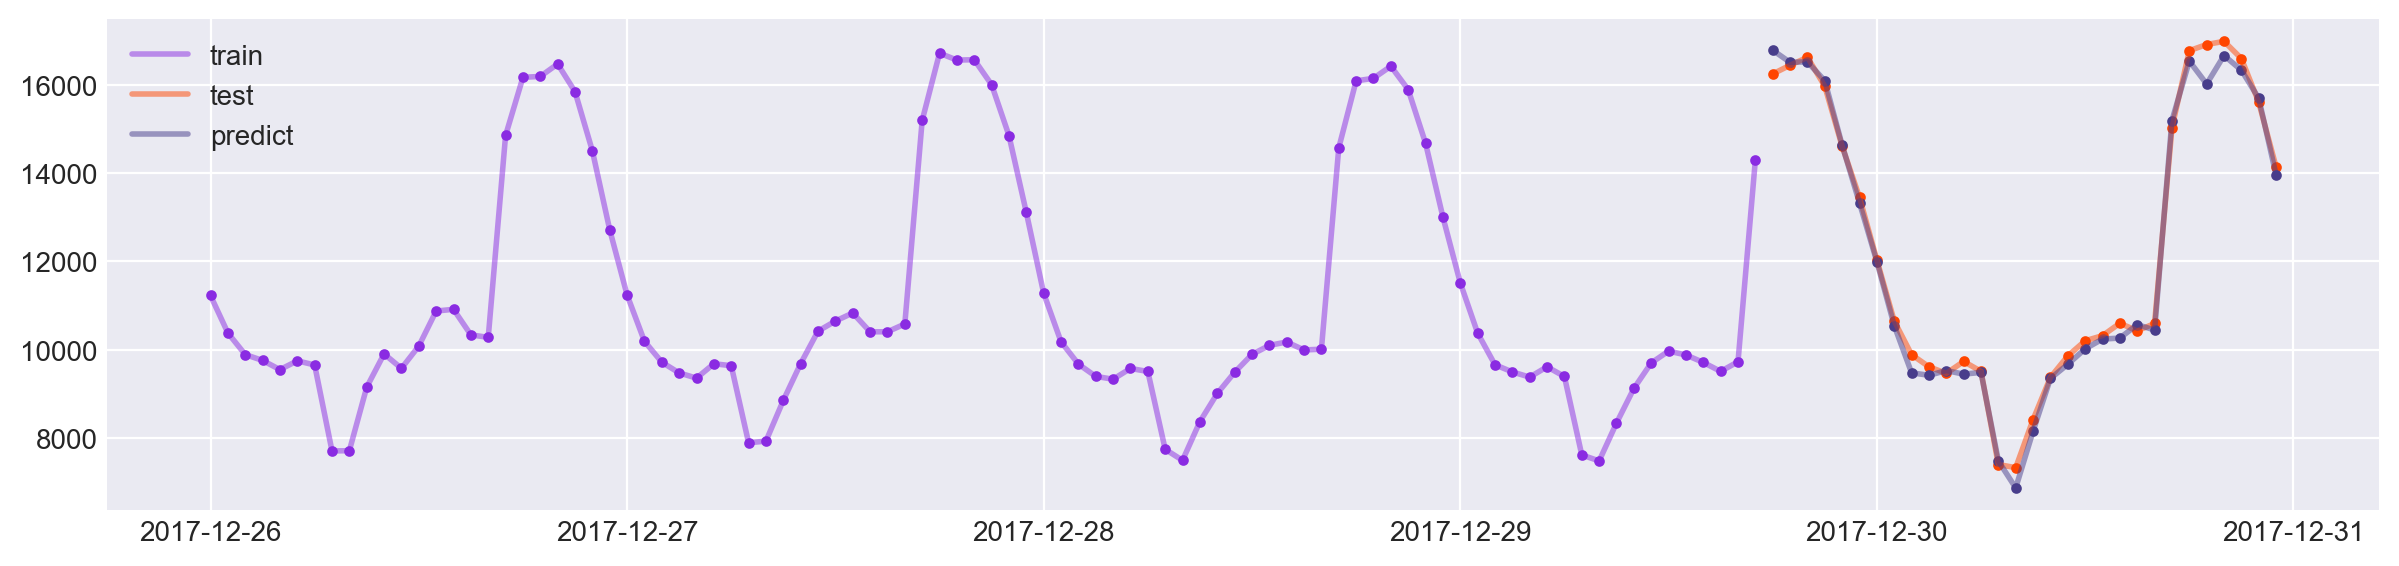

In [23]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

In [24]:
print(grid_search_results["params"])

{'l2_leaf_reg': 3}


In [25]:
del (
    train_data,
    test_data,
    train_data_feat,
    test_data_feat,
    train_x,
    train_y,
    test_x,
    test_y,
    train_pool,
    test_pool,
)

In [26]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model, yhat, model_name = None, None, None

model_name = "LSTM_Dense"

WINDOW_LEN = 24
BATCH_SIZE = 64
BUFFER_SIZE = 100
EPOCHS_ = 20

train_data, test_data = test_train_split(dataframe, test_size=WINDOW_LEN + 30)

build_features = lambda df: (
    df.pipe(create_lag_feature, column=target_column, lags=lags)
    .pipe(create_window_feature, column=target_column, window_len=window_length)
    .pipe(create_datetime_feature, features_name=dt_features)
    .pipe(create_cyclic_feature, features_name=cl_features)
    .pipe(cast_to_float)
)


def window_data(X_data, y_data, window_len=7):
    x_, y_ = [], []
    for i in range(window_len - 1, len(X_data)):
        x_.append(X_data[i - window_len + 1 : i + 1])
        y_.append(y_data[i])
    return np.array(x_), np.array(y_)


train_data_feat = build_features(train_data)
test_data_feat = build_features(test_data)

train_data_feat = train_data_feat[max(*lags) :]
test_data_feat.fillna(method="backfill", inplace=True)


train_x, train_y = seperate_target(train_data_feat, target_column)
test_x, test_y = seperate_target(test_data_feat, target_column)

scaler = StandardScaler().set_output(transform="pandas")
scaler.fit(train_x)

train_x = scaler.transform(train_x)
test_x = scaler.transform(test_x)

x_window = np.concatenate([train_x, test_x])
y_window = np.concatenate([train_y, test_y])


x_window, y_window = window_data(x_window, y_window, window_len=WINDOW_LEN)

x_train_data, x_test_data = x_window[: -len(test_x)], x_window[-len(test_x) :]
y_train_data, y_test_data = y_window[: -len(test_x)], y_window[-len(test_x) :]

train_data = (
    tf.data.Dataset.from_tensor_slices((x_train_data, y_train_data))
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
)


test_data = (
    tf.data.Dataset.from_tensor_slices((x_test_data, y_test_data))
    .batch(BATCH_SIZE)
    .repeat()
)

model = tf.keras.models.Sequential(
    [
        LSTM(128, input_shape=x_window.shape[-2:], dropout=0.0),
        Dense(128),
        Dense(128),
        Dense(1),
    ]
)

model.compile(optimizer="rmsprop", loss="mse", metrics="mae")

training_history = model.fit(
    train_data,
    epochs=EPOCHS_,
    steps_per_epoch=200,
    validation_data=test_data,
    validation_steps=50,
)
yhat = model.predict(x_test_data)
print(yhat.shape)

Epoch 1/20
200/200 [==============================] - 12s 45ms/step - loss: 169165248.0000 - mae: 10131.9941 - val_loss: 81962080.0000 - val_mae: 8505.2949
Epoch 2/20
200/200 [==============================] - 9s 42ms/step - loss: 16158594.0000 - mae: 2790.2439 - val_loss: 673435.6875 - val_mae: 635.8910
Epoch 3/20
200/200 [==============================] - 9s 47ms/step - loss: 2077815.3750 - mae: 1032.7841 - val_loss: 715959.1250 - val_mae: 692.1002
Epoch 4/20
200/200 [==============================] - 11s 53ms/step - loss: 1237837.6250 - mae: 805.5888 - val_loss: 3252690.5000 - val_mae: 1735.3950
Epoch 5/20
200/200 [==============================] - 10s 49ms/step - loss: 683847.6875 - mae: 613.1397 - val_loss: 772788.6875 - val_mae: 820.2387
Epoch 6/20
200/200 [==============================] - 9s 43ms/step - loss: 615450.8750 - mae: 578.6553 - val_loss: 385363.0000 - val_mae: 558.4150
Epoch 7/20
200/200 [==============================] - 8s 41ms/step - loss: 441979.2188 - mae: 488.9

In [27]:
resultsDict[model_name] = evaluate(y_test_data.flatten(), yhat.flatten())

predictionsDF[model_name] = yhat.flatten()[-len(predictionsDF.index) :]

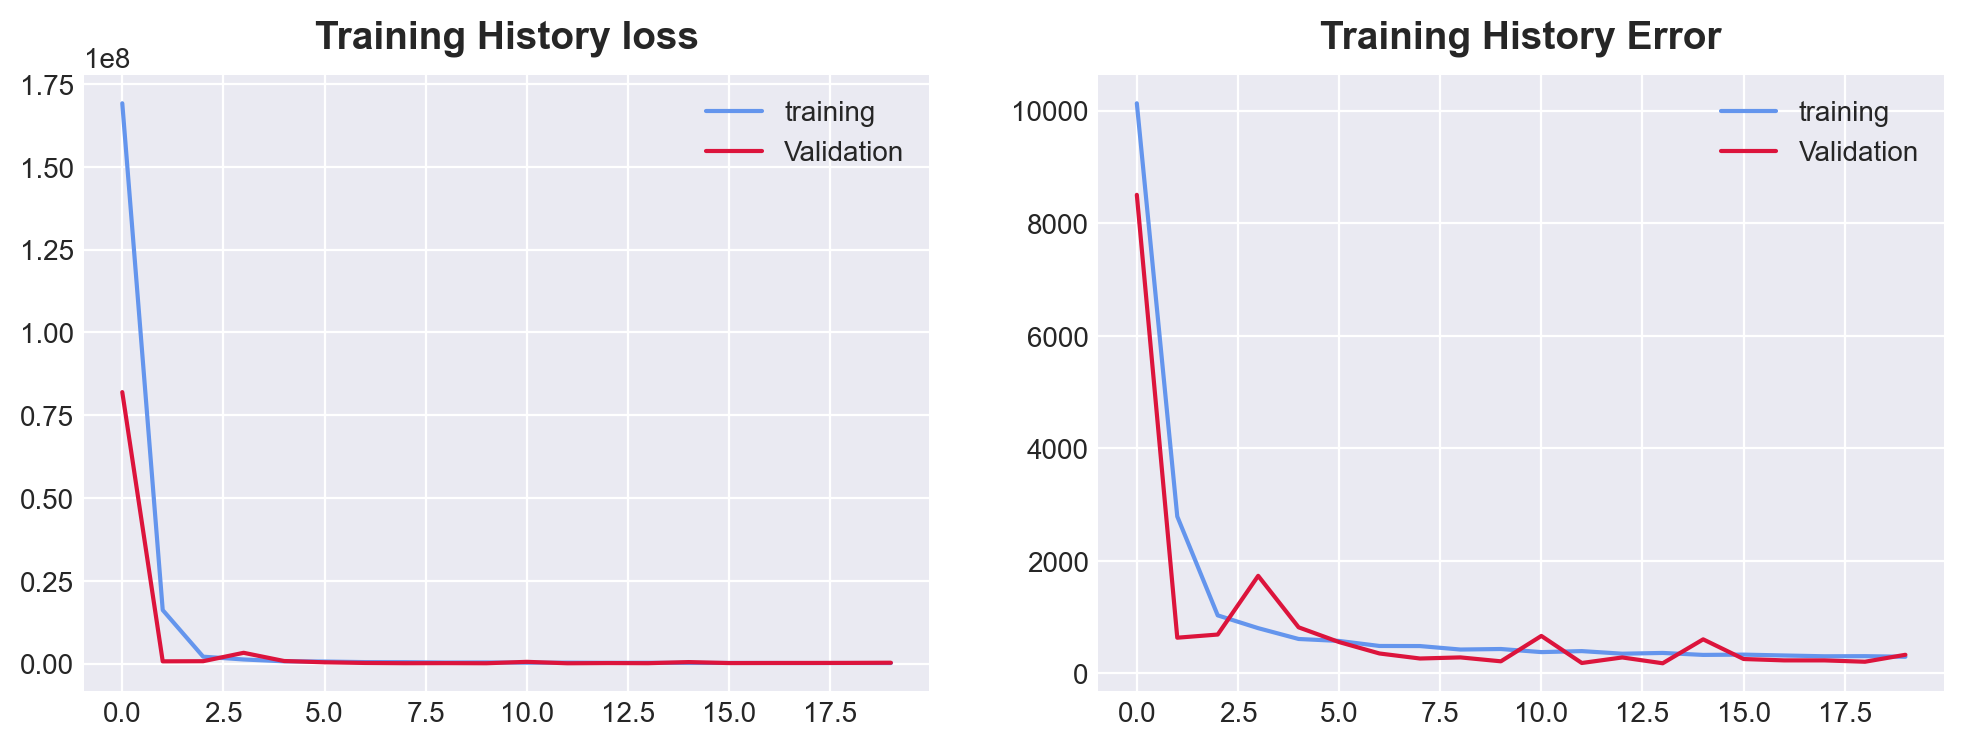

In [28]:
plot_tf_training_history(training_history)

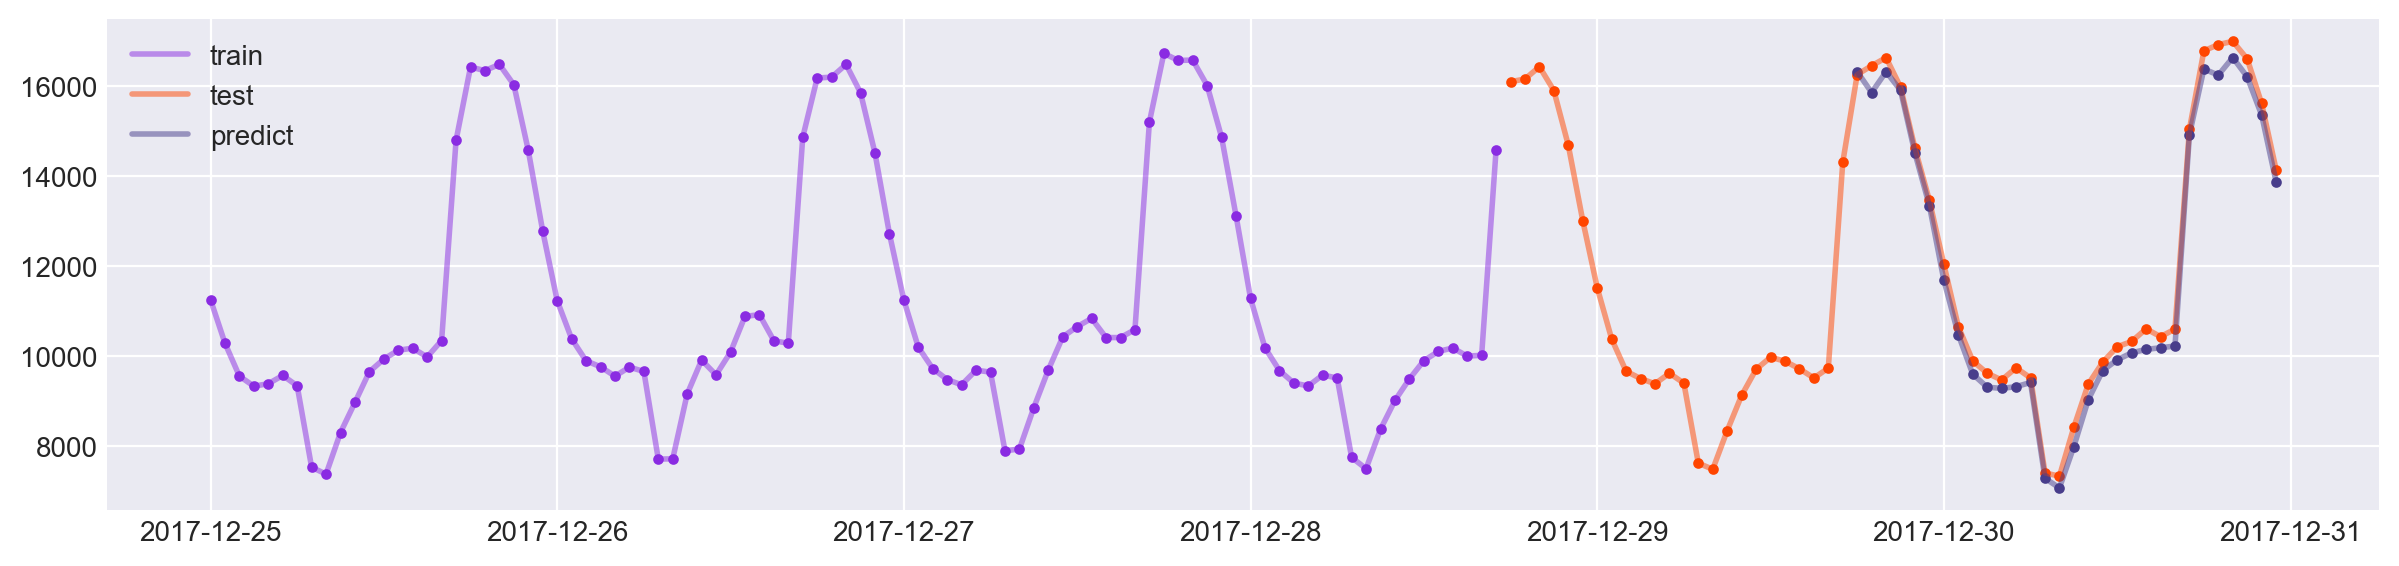

In [29]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

In [30]:
resultsDF = pd.DataFrame.from_dict(resultsDict)
resultsDF.head()

,KNeighborsRegressor,BayesianRidge,LassoCV,RandomForestRegressor,XGBRegressor,LGBMRegressor,CatBoostRegressor,LSTM_Dense
mae,895.590236,778.840907,97.507948,184.951518,162.353798,160.019017,205.523103,332.444303
rmse,1174.927303,966.848611,147.282558,225.351526,203.633785,209.847100,274.848219,503.135288
mape,0.080217,0.063810,0.008034,0.014554,0.013090,0.012968,0.017302,0.027060
r2,0.866671,0.909714,0.997905,0.995095,0.995995,0.995747,0.992704,0.973788


In [31]:
resultsDF.T

,mae,rmse,mape,r2
KNeighborsRegressor,895.590236,1174.927303,0.080217,0.866671
BayesianRidge,778.840907,966.848611,0.063810,0.909714
LassoCV,97.507948,147.282558,0.008034,0.997905
RandomForestRegressor,184.951518,225.351526,0.014554,0.995095
XGBRegressor,162.353798,203.633785,0.013090,0.995995
LGBMRegressor,160.019017,209.847100,0.012968,0.995747
CatBoostRegressor,205.523103,274.848219,0.017302,0.992704
LSTM_Dense,332.444303,503.135288,0.027060,0.973788


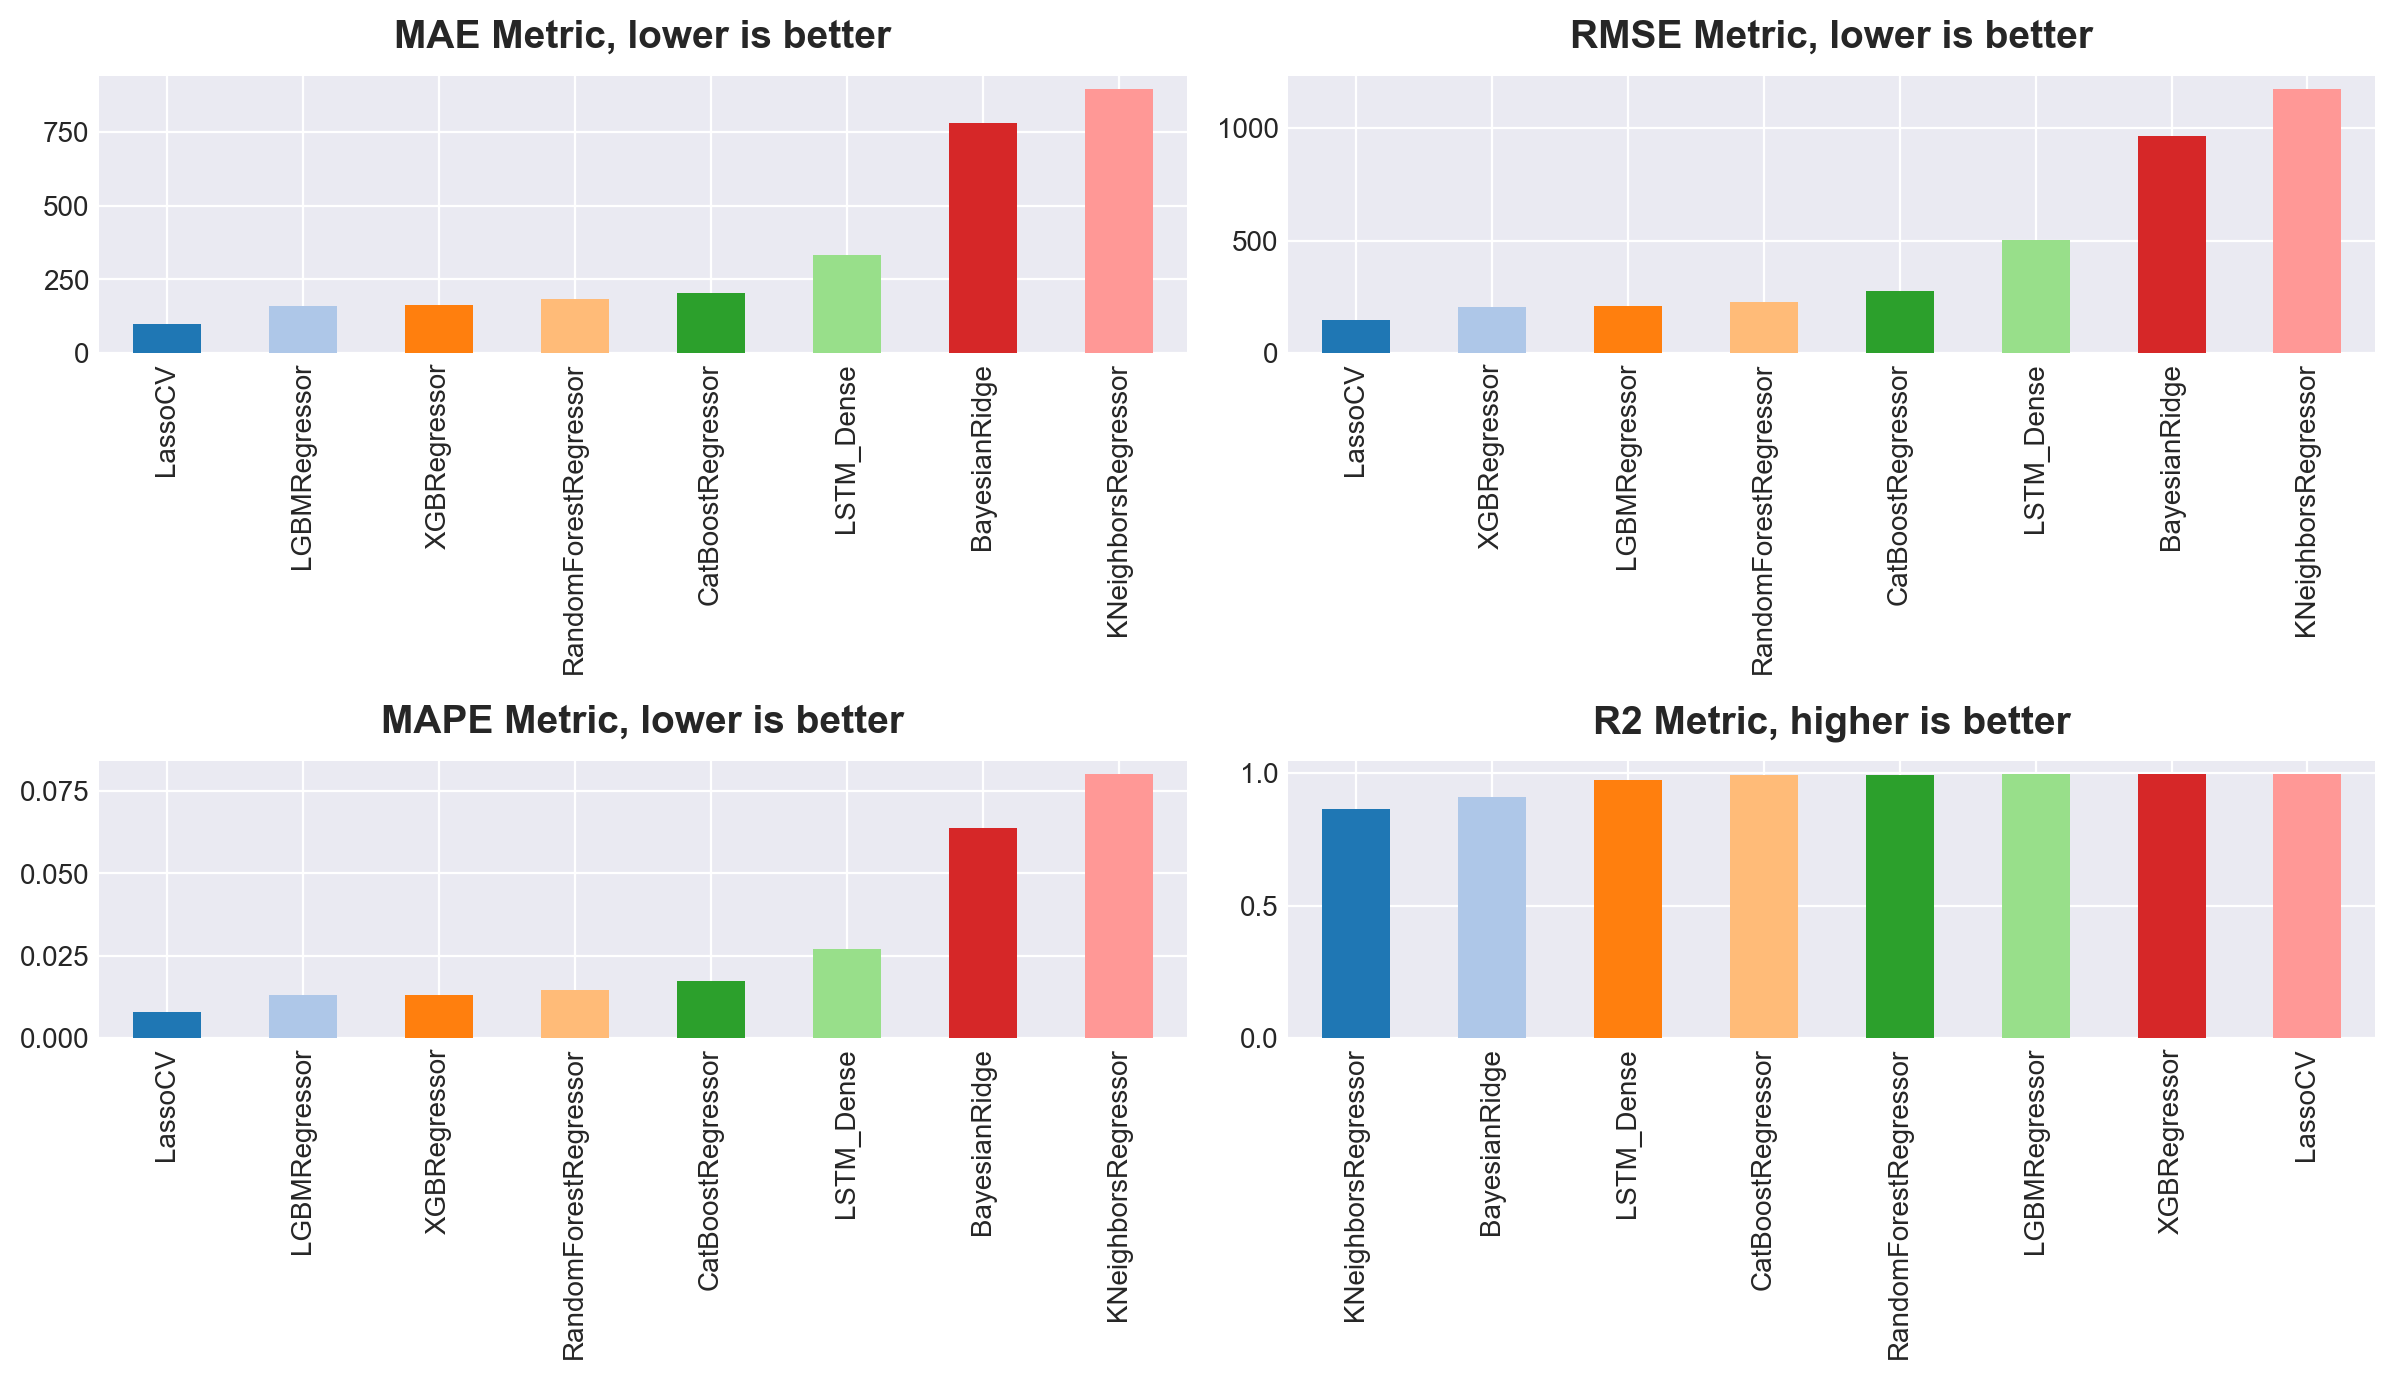

In [32]:
plot_metrics(resultsDF)

In [33]:
resultsDF_T = resultsDF.T.copy(deep=True)
resultsDF_T["Dataset"] = "Power_consumption"
resultsDF_T["Mode"] = "Singel_step"

result_path = "./results/results.csv"

if os.path.isfile(result_path) is False:
    resultsDF_T.to_csv(result_path, index=False)
else:
    result_data = pd.read_csv(result_path)
    if result_data[result_data["Dataset"] == "Power_consumption"].shape[0] > 0:
        result_data = result_data[result_data["Dataset"] != "Power_consumption"].copy()

    new_data = pd.concat([result_data, resultsDF_T])
    new_data.to_csv(result_path, index=False)